In [1]:
name="multifidelity_viscous_models"

In [2]:
#import GPy
import os
import pickle
import numpy as np
#import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from numpy.linalg import inv
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

import emcee
import ptemcee
import h5py
from scipy.linalg import lapack
from multiprocessing import Pool
from multiprocessing import cpu_count

### 1. Loading simulation data from all 4 models


In [3]:
#Saved emulator name
EMU='PbPb2760_emulators_scikit.dat'

In [4]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results_ldr"
FIGURE_ID = "Results_ldr/FigureFiles"
DATA_ID = "DataFiles/"

In [5]:
if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

In [6]:
# Bounds for parametrs in the emulator are same as prior ranges so
prior_df = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_prior", index_col=0)

In [7]:
# Design points
design = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_design")

In [8]:
#Simulation outputs at the design points
simulation_df = []
simulation_sd_df = []
for idf in range(0,4):
    simulation_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_simulation_{idf}"))
    simulation_sd_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_simulation_error_{idf}"))

In [9]:
simulation_df[1].head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,1574.895714,1270.145022,932.580707,630.400114,392.544409,238.067087,134.648096,63.153358,2076.364808,1835.374778,...,0.027404,0.028197,0.032930,0.033431,0.010413,0.012651,0.015070,0.016598,0.019399,0.018418
1,1355.748825,1123.747800,882.879650,623.828320,391.103401,248.354372,143.333354,74.139705,1709.947515,1558.404506,...,0.023901,0.024261,0.026591,0.025550,0.008862,0.009324,0.011560,0.011658,0.011654,0.011179
2,1683.290048,1388.180222,1054.952336,719.627087,485.381585,309.174111,178.829733,91.772220,2141.078413,1931.558080,...,0.019720,0.021377,0.019973,0.020431,0.007427,0.007059,0.007941,0.009942,0.009279,0.009743
3,1452.927190,1178.713111,903.853748,636.430243,432.280496,275.816643,157.583011,78.252521,1918.359572,1723.143686,...,0.018632,0.020882,0.022750,0.022269,0.006417,0.008370,0.009120,0.010369,0.011032,0.010482
4,1595.238857,1343.143714,1046.269294,714.085375,495.002760,316.201300,186.396580,97.918916,2141.459062,1910.787212,...,0.023834,0.027182,0.027454,0.027838,0.009052,0.009896,0.010766,0.012733,0.011812,0.012470


In [10]:
simulation_sd_df[2].head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,10.071746,7.241542,7.459288,4.580889,3.788967,2.348702,1.749008,0.930683,12.907602,6.926424,...,0.000932,0.001035,0.001123,0.000957,0.000717,0.000727,0.000542,0.000623,0.000712,0.000682
1,6.930275,4.541214,5.124968,4.545924,3.336955,2.297671,1.541077,0.974098,9.415680,6.885383,...,0.000893,0.000821,0.000915,0.000822,0.000694,0.000743,0.000568,0.000558,0.000570,0.000595
2,9.195409,6.241020,7.591831,4.909938,3.990199,2.788804,1.934193,1.274814,10.946934,8.336824,...,0.000736,0.000759,0.000712,0.000762,0.000633,0.000668,0.000503,0.000553,0.000527,0.000522
3,8.112782,6.235609,5.601630,4.364517,3.134108,2.717734,1.772125,1.072769,9.202123,6.837725,...,0.000750,0.000706,0.000802,0.000887,0.000733,0.000748,0.000514,0.000533,0.000507,0.000609
4,9.461200,5.717822,6.635984,5.138407,3.621117,2.715676,1.871730,1.382263,15.775991,7.174462,...,0.000769,0.000875,0.000871,0.000917,0.000807,0.000731,0.000617,0.000522,0.000518,0.000529


In [11]:
X = design.values


In [12]:
for idf in range(0,4):
    Y = simulation_df[idf].values
    print( "X.shape : "+ str(X.shape) )
    print( "Y.shape : "+ str(Y.shape) )

X.shape : (485, 17)
Y.shape : (485, 110)
X.shape : (485, 17)
Y.shape : (485, 110)
X.shape : (485, 17)
Y.shape : (485, 110)
X.shape : (485, 17)
Y.shape : (485, 110)


In [13]:
#Model parameter names in Latex compatble form
model_param_dsgn = ['$N$[$2.76$TeV]',
 '$p$',
 '$\\sigma_k$',
 '$w$ [fm]',
 '$d_{\\mathrm{min}}$ [fm]',
 '$\\tau_R$ [fm/$c$]',
 '$\\alpha$',
 '$T_{\\eta,\\mathrm{kink}}$ [GeV]',
 '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]',
 '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]',
 '$(\\eta/s)_{\\mathrm{kink}}$',
 '$(\\zeta/s)_{\\max}$',
 '$T_{\\zeta,c}$ [GeV]',
 '$w_{\\zeta}$ [GeV]',
 '$\\lambda_{\\zeta}$',
 '$b_{\\pi}$',
 '$T_{\\mathrm{sw}}$ [GeV]']

In [14]:
observables = ['dNch_deta',
 'dET_deta',
 'dN_dy_pion',
 'dN_dy_kaon',
 'dN_dy_proton',
 'mean_pT_pion',
 'mean_pT_kaon',
 'mean_pT_proton',
 'pT_fluct',
 'v22',
 'v32',
 'v42']

In [15]:
observables_latex_2 = ['$\\frac{dN_{ch}}{d\\eta}$',
 '$\\frac{dE_T}{d\\eta}$',
 '$\\frac{dN_{\\pi}}{dy}$',
 '$\\frac{dN_{K}}{dy}$',
 '$\\frac{dN_{P}}{dy}$',
 '$\\langle pT_{\\pi} \\rangle$',
 '$\\langle pT_{K} \\rangle$',
 '$\\langle pT_{P} \\rangle$',
 '$\\frac{\\delta p_T}{\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

In [16]:
observables_latex = ['$dN_{ch} / d\\eta$',
 '$dE_T / d\\eta$',
 '${dN_{\\pi}} / {dy}$',
 '${dN_{K}} / {dy}$',
 '${dN_{P}} / {dy}$',
 '$\\langle p_{T, \\pi} \\rangle$',
 '$\\langle p_{T, K} \\rangle$',
 '$\\langle p_{T, P} \\rangle$',
 '${\\delta p_T} / {\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

### For this analysis we will only consider one single observable.
#### $\langle p_{T, \pi} \rangle$ for the [0-5] centrality.

In [17]:
selected_observable = 'mean_pT_pion[0 5]'

In [18]:
simulation_df[0][selected_observable]

0      0.489027
1      0.492126
2      0.475687
3      0.509817
4      0.524599
         ...   
480    0.454609
481    0.628647
482    0.467832
483    0.589815
484    0.478744
Name: mean_pT_pion[0 5], Length: 485, dtype: float64

In [19]:
#Scaling the data to be zero mean and unit variance for each feature (110)
#SS  =  StandardScaler(copy=True)

# Linear multi-fidelity modeling in Emukit

In [20]:
import GPy
import emukit.multi_fidelity
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
## Convert lists of arrays to ndarrays augmented with fidelity indicators
from sklearn.model_selection import train_test_split
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
from sklearn.model_selection import KFold
from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel
from sklearn.metrics import r2_score, mean_squared_error

In [21]:
def run_train_and_validation(x_train_l, x_train_h, x_test_h, y_train_l, y_train_h, y_test_h):
    """ Train three types of emulators. And perform validation on a given set
            1. Linear multifidelity
            2. Nonlinear multifidelity
            3. Standard GP
        =============================
        Return:
            2 x 3 ndarray. 
            First row has MSE
            Second row has R2 scores
        """
    X_train, Y_train = convert_xy_lists_to_arrays([x_train_l, x_train_h], [y_train_l, y_train_h])
    n_opt = 5
    ## Construct a linear multi-fidelity model

    kernels = [GPy.kern.RBF(17, ARD=True), GPy.kern.RBF(17, ARD=True)]
    lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
    gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)
    #gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)
    #gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)


    ## Wrap the model using the given 'GPyMultiOutputWrapper'
    lin_mf_model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=n_opt)

    ## Fit the model
  
    lin_mf_model.optimize()
    ## Create nonlinear model


    base_kernel = GPy.kern.RBF
    kernels = make_non_linear_kernels(base_kernel, 2, X_train.shape[1]-1, ARD=True)
    nonlin_mf_model = NonLinearMultiFidelityModel(X_train, Y_train, n_fidelities=2, kernels=kernels,verbose=True, 
                                                  optimization_restarts=n_opt)
    #for m in nonlin_mf_model.models:
    #m.Gaussian_noise.variance.fix(0)
    
    nonlin_mf_model.optimize()
    
    ## Create standard GP model using only high-fidelity data

    kernel = GPy.kern.RBF(input_dim=17, ARD=True)
    high_gp_model = GPy.models.GPRegression(x_train_h,y_train_h, kernel)
    #high_gp_model.Gaussian_noise.fix(0)

    ## Fit the GP model
    
    high_gp_model.optimize_restarts(n_opt, verbose=True, parallel=True, num_processes=5)
    #print(high_gp_model)
    ## Compute mean predictions and associated variance

    #hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(x_plot)
    #hf_std_hf_gp_model = np.sqrt(hf_var_high_gp_model)
    x_temp = convert_x_list_to_array([x_test_h,x_test_h])
    x_test_h_idf_index = x_temp[x_test_h.shape[0]:,:]
    hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(x_test_h_idf_index)
    print(hf_mean_lin_mf_model.shape)
    r2_1 = r2_score(y_test_h,hf_mean_lin_mf_model )
    mse_1 = mean_squared_error(y_test_h,hf_mean_lin_mf_model )
    print(f'r2 score for multifidelity linear {r2_score(y_test_h,hf_mean_lin_mf_model )}')
    print(f'mse for multifidelity linear {mean_squared_error(y_test_h,hf_mean_lin_mf_model )}')
    
    hf_mean_nonlin_mf_model, hf_var_nonlin_mf_model = nonlin_mf_model.predict(x_test_h_idf_index)
    print(hf_mean_nonlin_mf_model.shape)
    r2_2 = r2_score(y_test_h,hf_mean_nonlin_mf_model )
    mse_2 = mean_squared_error(y_test_h,hf_mean_nonlin_mf_model )
    print(f'r2 score for multifidelity nonlinear {r2_score(y_test_h,hf_mean_nonlin_mf_model )}')
    print(f'mse for multifidelity nonlinear {mean_squared_error(y_test_h,hf_mean_nonlin_mf_model )}')
    

    hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(x_test_h)
    print(hf_mean_high_gp_model.shape)
    r2_3 = r2_score(y_test_h,hf_mean_high_gp_model)
    mse_3 = mean_squared_error(y_test_h,hf_mean_high_gp_model )
    print(f'r2 score for standard GP {r2_score(y_test_h,hf_mean_high_gp_model)}')
    print(f'mse for standard GP {mean_squared_error(y_test_h,hf_mean_high_gp_model )}')
    r2s= [r2_1, r2_2, r2_3]
    mses=[mse_1, mse_2, mse_3]
    return np.array([mses, r2s])

Optimization restart 1/5, f = -1129.9580462745862
Optimization restart 2/5, f = -1129.0223387156657
Optimization restart 3/5, f = -1113.0219681272383
Optimization restart 4/5, f = -1141.9618555619713
Optimization restart 5/5, f = -1006.7897223392653
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1073.157201356174
Optimization restart 3/5, f = -1072.6786254868039
Optimization restart 4/5, f = -1073.0968768051916
Optimization restart 5/5, f = -1072.6050604209145
Optimization restart 1/5, f = -40.74027064632528
Optimization restart 2/5, f = -39.31972007325324
Optimization restart 3/5, f = -27.200634101019922


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -63.11174332667751
Optimization restart 5/5, f = -59.578737621214614


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/5, f = -40.78524435231534
Optimization restart 2/5, f = -40.152764590911616
Optimization restart 3/5, f = -39.81520745897934
Optimization restart 4/5, f = -42.65227347927721
Optimization restart 5/5, f = -41.09048132190994
(97, 1)
r2 score for multifidelity linear 0.9848500352398545
mse for multifidelity linear 2.445792650421054e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9273910602338181
mse for multifidelity nonlinear 0.00011721902594926324
(97, 1)
r2 score for standard GP 0.4603120941381751
mse for standard GP 0.0008712658640304977
Optimization restart 1/5, f = -1209.6369674570215
Optimization restart 2/5, f = -1218.7292735251638
Optimization restart 3/5, f = -1214.8714859709887


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -1213.4301407250869
Optimization restart 5/5, f = -1180.2155532548109
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1073.1877226933825
Optimization restart 3/5, f = -1072.8582309066803
Optimization restart 4/5, f = -1072.7806304664048
Optimization restart 5/5, f = -1072.96030848883
Optimization restart 1/5, f = -79.61201564839348


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -87.02877808876853
Optimization restart 3/5, f = -60.724035109078


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -119.31077198873913
Optimization restart 5/5, f = -82.91988259276567
Optimization restart 1/5, f = -75.84680059559209
Optimization restart 2/5, f = -87.64979251008481
Optimization restart 3/5, f = -88.43804758548623
Optimization restart 4/5, f = -87.88065471281666
Optimization restart 5/5, f = -85.36319029521853
(97, 1)
r2 score for multifidelity linear 0.9876910240352029
mse for multifidelity linear 1.987146731067436e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9548747547471462
mse for multifidelity nonlinear 7.28496699069661e-05
(97, 1)
r2 score for standard GP 0.6874683935496317
mse for standard GP 0.0005045473822430542


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = -1246.1087874573777
Optimization restart 2/5, f = -1176.7026887789013
Optimization restart 3/5, f = -1265.243045494238
Optimization restart 4/5, f = -1282.7327470032944
Optimization restart 5/5, f = -1262.8691780300228
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1073.1055314353575
Optimization restart 3/5, f = -1072.7549931542235
Optimization restart 4/5, f = -1072.6538265879622
Optimization restart 5/5, f = -1072.6746695815618
Optimization restart 1/5, f = -129.78146118099946
Optimization restart 2/5, f = -191.23771577742846
Optimization restart 3/5, f = -186.54286093321903
Optimization restart 4/5, f = -180.8851348101246


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -189.66081313336085
Optimization restart 1/5, f = -129.76816004961114
Optimization restart 2/5, f = -103.85113498652149
Optimization restart 3/5, f = -132.83867210618746
Optimization restart 4/5, f = -132.9573924543521
Optimization restart 5/5, f = -129.77215133384865
(97, 1)
r2 score for multifidelity linear 0.976565350724628
mse for multifidelity linear 3.783262461024304e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9535250293522747
mse for multifidelity nonlinear 7.502865085057056e-05
(97, 1)
r2 score for standard GP 0.712041198964011
mse for standard GP 0.0004648773316295912
Optimization restart 1/5, f = -1368.7405613098442


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -1321.4987729133254


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1361.6493061351703
Optimization restart 4/5, f = -1374.308407056828
Optimization restart 5/5, f = -1351.9816511340775
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1073.1493525698986
Optimization restart 3/5, f = -1072.8582471432321
Optimization restart 4/5, f = -1072.7725879360894
Optimization restart 5/5, f = -1072.9589331924399
Optimization restart 1/5, f = -177.9089583390128
Optimization restart 2/5, f = -177.90946687930148
Optimization restart 3/5, f = -230.7977952062776
Optimization restart 4/5, f = -177.9068217771506
Optimization restart 5/5, f = -252.90674308797244
Optimization restart 1/5, f = -177.8993623398885
Optimization restart 2/5, f = -177.90705117082663
Optimization restart 3/5, f = -177.78600748024525
Optimization restart 4/5, f = -177.9086726363778
Optimization restart 5/5, f = -177.89695589763244
(97, 1)
r2 score for multifidelity linear 0.9890813727859618
mse for multifidelity linear 1.762690449487588

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -1264.4369154012174


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -1439.5094085830888
Optimization restart 4/5, f = -1395.0038394891178
Optimization restart 5/5, f = -1447.9879704405507
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1073.0498351099154
Optimization restart 3/5, f = -1072.8031446112755
Optimization restart 4/5, f = -1072.7662514673343
Optimization restart 5/5, f = -1073.016294970992
Optimization restart 1/5, f = -304.29994034907156
Optimization restart 2/5, f = -230.79991720940228
Optimization restart 3/5, f = -290.2127506220265
Optimization restart 4/5, f = -294.0127741408206
Optimization restart 5/5, f = -231.17843523730596
Optimization restart 1/5, f = -230.84751637464086
Optimization restart 2/5, f = -216.76124050277068
Optimization restart 3/5, f = -230.75814671498077
Optimization restart 4/5, f = -192.13524020201555
Optimization restart 5/5, f = -221.7625953109229
(97, 1)
r2 score for multifidelity linear 0.9838723585909946
mse for multifidelity linear 2.6036276289260

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -1472.1330114470804
Optimization restart 5/5, f = -1625.0716608801679
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1072.8770151313686
Optimization restart 3/5, f = -1072.6042971461434
Optimization restart 4/5, f = -1073.1288052259574
Optimization restart 5/5, f = -1072.9609153043743
Optimization restart 1/5, f = -269.32627389945327
Optimization restart 2/5, f = -367.91736568377166


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -388.81151022242125
Optimization restart 4/5, f = -271.11330570267637
Optimization restart 5/5, f = -358.32461299210735
Optimization restart 1/5, f = -269.3633880387835
Optimization restart 2/5, f = -259.80322157741836
Optimization restart 3/5, f = 89.28574855897642
Optimization restart 4/5, f = -275.9090330372835
Optimization restart 5/5, f = -271.10655496803645
(97, 1)
r2 score for multifidelity linear 0.985138974791901
mse for multifidelity linear 2.399146585958218e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9787573466068952
mse for multifidelity nonlinear 3.42938920102138e-05
(97, 1)
r2 score for standard GP 0.9081490825022639
mse for standard GP 0.00014828305049353473
Optimization restart 1/5, f = -1729.7607254745003


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1579.572603958226


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -1548.6892591056003
Optimization restart 4/5, f = -1461.9198004635405


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -1488.114840760973
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1072.7419800977232


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1072.8985189728376
Optimization restart 4/5, f = -909.1818364503317
Optimization restart 5/5, f = -1072.803311956668
Optimization restart 1/5, f = -314.76272656276933
Optimization restart 2/5, f = -409.6473188286062
Optimization restart 3/5, f = -314.76295293394656
Optimization restart 4/5, f = -314.7629830587447
Optimization restart 5/5, f = -453.25563847311724
Optimization restart 1/5, f = -328.7985880543132
Optimization restart 2/5, f = -314.7629612913437
Optimization restart 3/5, f = -314.76297361310117
Optimization restart 4/5, f = -326.1191781639248
Optimization restart 5/5, f = -314.6333820165111
(97, 1)
r2 score for multifidelity linear 0.9850903342130289
mse for multifidelity linear 2.406999064310536e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9782396290694643
mse for multifidelity nonlinear 3.5129689167560085e-05
(97, 1)
r2 score for standard GP 0.9372999688599426
mse for standard GP 0.00010122219937233059
Optimization restart 1/5, f = -1

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -1070.7727523874132


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -1653.662645174187
Optimization restart 5/5, f = -1472.0604739465748
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1072.760603275165
Optimization restart 3/5, f = -1072.6750598797344
Optimization restart 4/5, f = -1072.6981155572755
Optimization restart 5/5, f = -1073.1668876786628
Optimization restart 1/5, f = -484.40094903721973
Optimization restart 2/5, f = -469.93018111270254


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -518.7270976783564
Optimization restart 4/5, f = -374.22075300834945
Optimization restart 5/5, f = -465.54916621947996
Optimization restart 1/5, f = -374.1640872645087
Optimization restart 2/5, f = -374.4593250349
Optimization restart 3/5, f = -374.6073778319513
Optimization restart 4/5, f = -373.6321541849442
Optimization restart 5/5, f = -374.82761363023576
(97, 1)
r2 score for multifidelity linear 0.9842661615087008
mse for multifidelity linear 2.5400525449513792e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9779736201225451
mse for multifidelity nonlinear 3.555913091057512e-05
(97, 1)
r2 score for standard GP 0.9467861991590745
mse for standard GP 8.590773975929363e-05
Optimization restart 1/5, f = -1932.750376559377


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -1729.1162928324916


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -1743.3531808150358
Optimization restart 4/5, f = -1714.922899069531
Optimization restart 5/5, f = -1711.9629472029324
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1072.9812105474039
Optimization restart 3/5, f = -1073.1300927791658
Optimization restart 4/5, f = -1016.8760015161506
Optimization restart 5/5, f = -1072.9734464693474
Optimization restart 1/5, f = -430.55012377841643
Optimization restart 2/5, f = -547.765198583201
Optimization restart 3/5, f = -429.95554317551756
Optimization restart 4/5, f = -430.79717003383416
Optimization restart 5/5, f = -529.2178583382771
Optimization restart 1/5, f = -430.7403226482882
Optimization restart 2/5, f = -430.26435420240983
Optimization restart 3/5, f = -448.7423896035639
Optimization restart 4/5, f = -430.6617987441784
Optimization restart 5/5, f = -430.56246111371325
(97, 1)
r2 score for multifidelity linear 0.9844218173692804
mse for multifidelity linear 2.514923644268922e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -1694.4591353648195
Optimization restart 4/5, f = -1796.9618076716733


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -1859.3370766686298
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1072.9463924784673
Optimization restart 3/5, f = -1073.0223673341352
Optimization restart 4/5, f = -1072.8613211008283
Optimization restart 5/5, f = -1073.0512403891569
Optimization restart 1/5, f = -484.7088624341028
Optimization restart 2/5, f = -494.32570225882705
Optimization restart 3/5, f = -584.6020919241959
Optimization restart 4/5, f = -586.5354575000097
Optimization restart 5/5, f = -484.49210124616275


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = -485.24414579356835
Optimization restart 2/5, f = -504.81768282860685
Optimization restart 3/5, f = -484.70962047239914
Optimization restart 4/5, f = -484.4821604278071
Optimization restart 5/5, f = -484.27571282530596
(97, 1)
r2 score for multifidelity linear 0.9846620909939697
mse for multifidelity linear 2.476134150388309e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9783933740324308
mse for multifidelity nonlinear 3.4881485091566586e-05
(97, 1)
r2 score for standard GP 0.9581672916995457
mse for standard GP 6.753423663242625e-05
Optimization restart 1/5, f = -2126.3552106383504
Optimization restart 2/5, f = -1876.9132232432885


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -1922.3899765000285
Optimization restart 4/5, f = -1896.1843559983872
Optimization restart 5/5, f = -1921.724131624736
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1073.2639636880226
Optimization restart 3/5, f = -1073.1506311049047
Optimization restart 4/5, f = -1072.9737082420609
Optimization restart 5/5, f = -1073.1173449245375
Optimization restart 1/5, f = -535.6027566643581
Optimization restart 2/5, f = -556.3291942476624
Optimization restart 3/5, f = -632.8082455474782
Optimization restart 4/5, f = -634.0033219042551
Optimization restart 5/5, f = -535.8223350603472
Optimization restart 1/5, f = -535.1705984153996
Optimization restart 2/5, f = -534.2165034315549
Optimization restart 3/5, f = -534.4086177256647
Optimization restart 4/5, f = -534.7309474070363
Optimization restart 5/5, f = -534.958991360943
(97, 1)
r2 score for multifidelity linear 0.9847271337935344
mse for multifidelity linear 2.46563371664759e-05
(9

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -2002.5031704906057


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -1954.3716526827302
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1073.1333553001284
Optimization restart 3/5, f = -1072.7615415721211
Optimization restart 4/5, f = -1072.5807026944203
Optimization restart 5/5, f = -1072.7713345741531
Optimization restart 1/5, f = -583.7515050866132
Optimization restart 2/5, f = -710.824285218999
Optimization restart 3/5, f = -785.146135422164


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -783.8637128528823
Optimization restart 5/5, f = -775.8433110974172
Optimization restart 1/5, f = -605.1751881986332
Optimization restart 2/5, f = -605.2614366989689
Optimization restart 3/5, f = -604.7767285051664
Optimization restart 4/5, f = -584.1351674872889
Optimization restart 5/5, f = -584.1489660423927
(97, 1)
r2 score for multifidelity linear 0.9838938055003805
mse for multifidelity linear 2.6001652648757033e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9757074292908715
mse for multifidelity nonlinear 3.9217642972028505e-05
(97, 1)
r2 score for standard GP 0.9704717904229863
mse for standard GP 4.7669997328006205e-05
Optimization restart 1/5, f = -2322.4684183448917


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -2071.8812946811445
Optimization restart 3/5, f = -2080.3009769045893


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -2001.945306012534
Optimization restart 5/5, f = -2063.4137641012207
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1072.7833675493152
Optimization restart 3/5, f = -1073.052801060691
Optimization restart 4/5, f = -1072.8786333488779
Optimization restart 5/5, f = -1072.7298323333798
Optimization restart 1/5, f = -644.3895880558744
Optimization restart 2/5, f = -791.1130193816755
Optimization restart 3/5, f = -756.310832049233


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -859.688871333446
Optimization restart 5/5, f = -756.2988913621882
Optimization restart 1/5, f = -640.862452508511
Optimization restart 2/5, f = -666.5623034944609
Optimization restart 3/5, f = -641.3366762932985
Optimization restart 4/5, f = -644.2611915444453
Optimization restart 5/5, f = -644.3920178256162
(97, 1)
r2 score for multifidelity linear 0.9847939792435725
mse for multifidelity linear 2.454842265115811e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9763692301414014
mse for multifidelity nonlinear 3.814923939360807e-05
(97, 1)
r2 score for standard GP 0.9740576933466907
mse for standard GP 4.188095744918651e-05
Optimization restart 1/5, f = -2412.8798215453444
Optimization restart 2/5, f = -1950.362394930279


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -2079.9385894134457


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -2158.8855217156633
Optimization restart 5/5, f = -2127.9403977745733
Optimization restart 1/5, f = -1072.697315759001


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1072.4806662560156
Optimization restart 3/5, f = -1073.004218468338
Optimization restart 4/5, f = -1072.7891205351395
Optimization restart 5/5, f = -1072.7277763811176
Optimization restart 1/5, f = -692.894039937748
Optimization restart 2/5, f = -937.1003153532989
Optimization restart 3/5, f = -693.263902085883
Optimization restart 4/5, f = -914.3488820388905
Optimization restart 5/5, f = -845.2691582047578
Optimization restart 1/5, f = -693.2210221685212
Optimization restart 2/5, f = -720.3246639624886
Optimization restart 3/5, f = -720.5797341860473
Optimization restart 4/5, f = -684.0715978709468
Optimization restart 5/5, f = -693.1035823893322
(97, 1)
r2 score for multifidelity linear 0.9845905589134173
mse for multifidelity linear 2.4876822060870673e-05
(97, 1)
r2 score for multifidelity nonlinear 0.972199127512993
mse for multifidelity nonlinear 4.4881404465630794e-05
(97, 1)
r2 score for standard GP 0.9776040372666198
mse for standard GP 3.61557811

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -779.7328039482143
Optimization restart 3/5, f = -865.5726788559124
Optimization restart 4/5, f = -753.2602075439262
Optimization restart 5/5, f = -893.5665751392432
Optimization restart 1/5, f = -752.9754909699288
Optimization restart 2/5, f = -753.2176424235408
Optimization restart 3/5, f = -779.9019586272311
Optimization restart 4/5, f = -753.2057456108338
Optimization restart 5/5, f = -753.062773902295
(97, 1)
r2 score for multifidelity linear 0.9838628887636489
mse for multifidelity linear 2.6051564268137188e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9846232321299242
mse for multifidelity nonlinear 2.482407480101676e-05
(97, 1)
r2 score for standard GP 0.9795828715215698
mse for standard GP 3.2961174211185007e-05
Optimization restart 1/5, f = -2616.6817511714244
Optimization restart 2/5, f = -2269.0886285927018
Optimization restart 3/5, f = -2568.2907727872052
Optimization restart 4/5, f = -2180.787479179139


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -2233.5758923657977
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1072.8049158576623


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -871.853333769729
Optimization restart 4/5, f = -1072.7418034373775


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -1072.6055373841473
Optimization restart 1/5, f = -812.0220802429262
Optimization restart 2/5, f = -930.076833484306
Optimization restart 3/5, f = -930.1863717643166
Optimization restart 4/5, f = -840.1149802044417
Optimization restart 5/5, f = -1049.1875542554308
Optimization restart 1/5, f = -840.2574578235657
Optimization restart 2/5, f = -811.9791828846228
Optimization restart 3/5, f = -693.6357503302415
Optimization restart 4/5, f = -812.1609178374986
Optimization restart 5/5, f = -812.8756800775069
(97, 1)
r2 score for multifidelity linear 0.9856364890986108
mse for multifidelity linear 2.318828456240107e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9811440559891089
mse for multifidelity nonlinear 3.0440816205664365e-05
(97, 1)
r2 score for standard GP 0.9804379473671758
mse for standard GP 3.1580749733738294e-05
Optimization restart 1/5, f = -2431.423904504762


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -2323.8584318256094
Optimization restart 3/5, f = -2375.455954011974
Optimization restart 4/5, f = -2686.1007129271234
Optimization restart 5/5, f = -2133.380004268304
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1072.9095681512053
Optimization restart 3/5, f = -1073.2278439420795
Optimization restart 4/5, f = -1072.8322187923031
Optimization restart 5/5, f = -1072.8948737815044
Optimization restart 1/5, f = -869.0938976100383
Optimization restart 2/5, f = -957.4298841735107
Optimization restart 3/5, f = -897.097397571373


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -1120.7425320104905


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -1125.0776150430954
Optimization restart 1/5, f = -868.8089598455338
Optimization restart 2/5, f = -868.4963264854242
Optimization restart 3/5, f = -896.8384421916635
Optimization restart 4/5, f = -896.684084823399
Optimization restart 5/5, f = -868.2820097832198
(97, 1)
r2 score for multifidelity linear 0.9838539888360034
mse for multifidelity linear 2.6065932207580838e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9818471333308583
mse for multifidelity nonlinear 2.9305776340983122e-05
(97, 1)
r2 score for standard GP 0.9815561742343492
mse for standard GP 2.97754973146498e-05
Optimization restart 1/5, f = -2807.879051740365


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -2450.9218389415278
Optimization restart 3/5, f = -2462.7897847329277
Optimization restart 4/5, f = -2422.426417230473
Optimization restart 5/5, f = -2464.381397835138
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1073.0796875323374
Optimization restart 3/5, f = -1073.2117465688002
Optimization restart 4/5, f = -1072.6842512893425
Optimization restart 5/5, f = -1073.094558352271
Optimization restart 1/5, f = -914.4379496204809
Optimization restart 2/5, f = -914.1208455740721
Optimization restart 3/5, f = -1093.2967705078313
Optimization restart 4/5, f = -1005.5591629191367
Optimization restart 5/5, f = -948.7114265535279
Optimization restart 1/5, f = -948.6298620915929
Optimization restart 2/5, f = -914.6116755038497
Optimization restart 3/5, f = -914.1523198312493
Optimization restart 4/5, f = -948.7033265113521
Optimization restart 5/5, f = -914.467743674286
(97, 1)
r2 score for multifidelity linear 0.9857072489458545
ms

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -2535.8795380816528


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -2518.4733888998494
Optimization restart 4/5, f = -2531.2148949031907
Optimization restart 5/5, f = -2551.4227863049
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1073.2794949530874
Optimization restart 3/5, f = -1073.0104820327833
Optimization restart 4/5, f = -1072.820059179493
Optimization restart 5/5, f = -1072.807439482801
Optimization restart 1/5, f = -973.382442887605


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -1009.7558174542518
Optimization restart 3/5, f = -973.2798108039143
Optimization restart 4/5, f = -1009.4257247123205
Optimization restart 5/5, f = -1146.1015975074397
Optimization restart 1/5, f = -973.0420577879512
Optimization restart 2/5, f = -973.6271753785836
Optimization restart 3/5, f = -1009.8569427889621
Optimization restart 4/5, f = -973.0403806793674
Optimization restart 5/5, f = -973.5020033704558
(97, 1)
r2 score for multifidelity linear 0.9856453331281484
mse for multifidelity linear 2.317400686421138e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9896571385351274
mse for multifidelity nonlinear 1.6697394981178437e-05
(97, 1)
r2 score for standard GP 0.9858502728025132
mse for standard GP 2.2843154642917745e-05
Optimization restart 1/5, f = -3037.4030192349346


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -2628.782602262604
Optimization restart 3/5, f = -2663.251127929645
Optimization restart 4/5, f = -2642.033349653849
Optimization restart 5/5, f = -2641.1254032469237
Optimization restart 1/5, f = -1072.697315759001
Optimization restart 2/5, f = -1072.7980208315862


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -1028.0185795132863
Optimization restart 4/5, f = -1072.8464798066618
Optimization restart 5/5, f = -1072.713170573655
Optimization restart 1/5, f = -1047.1720369751606
Optimization restart 2/5, f = -1220.3294204272584
Optimization restart 3/5, f = -818.1036289329377
Optimization restart 4/5, f = -1047.8392940603544
Optimization restart 5/5, f = -1338.0666694579118
Optimization restart 1/5, f = -1047.3243460963683
Optimization restart 2/5, f = -1081.1096264904018
Optimization restart 3/5, f = -1048.4354775700674
Optimization restart 4/5, f = -1048.012907085507
Optimization restart 5/5, f = -1047.615007752653
(97, 1)
r2 score for multifidelity linear 0.986012014423354
mse for multifidelity linear 2.2582040855669825e-05
(97, 1)
r2 score for multifidelity nonlinear 0.982149648847312
mse for multifidelity nonlinear 2.881739881767208e-05
(97, 1)
r2 score for standard GP 0.9892332795412564
mse for standard GP 1.738166799991961e-05
Optimization restart 1/5, f = -

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -1148.4500813997358


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -1128.9144447634076
Optimization restart 5/5, f = -1178.6672047296122
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1096.3944030315972
Optimization restart 3/5, f = -1095.887341854414
Optimization restart 4/5, f = -1095.5759365666843
Optimization restart 5/5, f = -1096.4301496108587
Optimization restart 1/5, f = -56.97896143144963
Optimization restart 2/5, f = -55.16401473025333
Optimization restart 3/5, f = -41.87553891205275
Optimization restart 4/5, f = -73.3592479521153
Optimization restart 5/5, f = -72.4962818357881
Optimization restart 1/5, f = -56.9896265847315
Optimization restart 2/5, f = -54.795252688140486
Optimization restart 3/5, f = -54.45218072835825
Optimization restart 4/5, f = -53.01458264114696
Optimization restart 5/5, f = -56.385875920886676
(97, 1)
r2 score for multifidelity linear 0.9800475682888825
mse for multifidelity linear 7.209963887422391e-05
(97, 1)
r2 score for multifidelity nonlinear 0.8066

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -1018.8423047726667
Optimization restart 5/5, f = -1095.6945408862587
Optimization restart 1/5, f = -113.52987255635104
Optimization restart 2/5, f = -154.54582892622597
Optimization restart 3/5, f = -138.35520175723144
Optimization restart 4/5, f = -113.10160566333852
Optimization restart 5/5, f = -137.2662861379696
Optimization restart 1/5, f = -112.80190621341131
Optimization restart 2/5, f = -113.26287199622132
Optimization restart 3/5, f = -113.63034209576557
Optimization restart 4/5, f = -113.45106442311743
Optimization restart 5/5, f = -113.33422792253381
(97, 1)
r2 score for multifidelity linear 0.9863757632637115
mse for multifidelity linear 4.9232222059228724e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9568589258065896
mse for multifidelity nonlinear 0.00015589357302537923
(97, 1)
r2 score for standard GP 0.7168763966561702
mse for standard GP 0.0010230888070893597
Optimization restart 1/5, f = -1392.1326283548933
Optimization restart 2/5,

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -1332.9515821682267


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -1071.8255538909257
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1095.8159053384097
Optimization restart 3/5, f = -1095.8905662089692
Optimization restart 4/5, f = -1096.054870782643
Optimization restart 5/5, f = -1095.0226452604602
Optimization restart 1/5, f = -164.72712195079941
Optimization restart 2/5, f = -228.51441586746415


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -164.88177338088164
Optimization restart 4/5, f = -164.69054160597852
Optimization restart 5/5, f = -215.96333871956998
Optimization restart 1/5, f = -167.55872858130064
Optimization restart 2/5, f = -167.46585475135026
Optimization restart 3/5, f = -164.75085676033942
Optimization restart 4/5, f = -168.11462013925558
Optimization restart 5/5, f = -164.6929446106514
(97, 1)
r2 score for multifidelity linear 0.9855939690198432
mse for multifidelity linear 5.20572953872805e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9717797862952701
mse for multifidelity nonlinear 0.00010197590181104267
(97, 1)
r2 score for standard GP 0.830243792992265
mse for standard GP 0.0006134270448396468
Optimization restart 1/5, f = -1499.4037914872415
Optimization restart 2/5, f = -1490.3790541428862
Optimization restart 3/5, f = -1410.8455120632502


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -1253.4927979398915
Optimization restart 5/5, f = -1411.320489318219
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1095.9306049536406
Optimization restart 3/5, f = -1095.8853948572337
Optimization restart 4/5, f = -1096.0010020814573
Optimization restart 5/5, f = -1095.8354458611932
Optimization restart 1/5, f = -224.6859392312371
Optimization restart 2/5, f = -305.72090956709303
Optimization restart 3/5, f = -271.9556030798677
Optimization restart 4/5, f = -303.67507172355937
Optimization restart 5/5, f = -224.54509700407675
Optimization restart 1/5, f = -224.55450429732923
Optimization restart 2/5, f = -223.65001803227483
Optimization restart 3/5, f = -226.01471272452727
Optimization restart 4/5, f = -224.71429917149263
Optimization restart 5/5, f = -224.57310194226875
(97, 1)
r2 score for multifidelity linear 0.9857022715499144
mse for multifidelity linear 5.166593590687439e-05
(97, 1)
r2 score for multifidelity nonline

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -1444.8339450718709
Optimization restart 5/5, f = -1500.3287916625984
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1095.7667755360922
Optimization restart 3/5, f = -1096.1813815833823
Optimization restart 4/5, f = -1095.9743925896191
Optimization restart 5/5, f = -1095.9231904692708
Optimization restart 1/5, f = -288.1981192677229
Optimization restart 2/5, f = -286.0312251688105
Optimization restart 3/5, f = -286.0320023298386
Optimization restart 4/5, f = -288.2028354631353
Optimization restart 5/5, f = -366.465763347849
Optimization restart 1/5, f = -288.1107787860818
Optimization restart 2/5, f = -286.0280436848923
Optimization restart 3/5, f = -286.06094447177156
Optimization restart 4/5, f = -286.03694215501685
Optimization restart 5/5, f = -286.02858353852184
(97, 1)
r2 score for multifidelity linear 0.986306065463368
mse for multifidelity linear 4.9484080394486054e-05
(97, 1)
r2 score for multifidelity nonlinear 0.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -1425.2252073728505


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -1561.7181291407892
Optimization restart 5/5, f = -1509.4432073800676
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1096.121205746213


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1095.5546675817159
Optimization restart 4/5, f = -1095.8233825240186
Optimization restart 5/5, f = -1024.0637295117413
Optimization restart 1/5, f = -333.44491934826806
Optimization restart 2/5, f = -333.33394744153964
Optimization restart 3/5, f = -397.8852205234147
Optimization restart 4/5, f = -411.6444543108537
Optimization restart 5/5, f = -331.67659759622927
Optimization restart 1/5, f = -333.26255060612954
Optimization restart 2/5, f = -331.6691119567103
Optimization restart 3/5, f = -331.57122890660725
Optimization restart 4/5, f = -333.3383517099314
Optimization restart 5/5, f = -333.52035672013636
(97, 1)
r2 score for multifidelity linear 0.9863719152050193
mse for multifidelity linear 4.924612731379062e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9464098584137167
mse for multifidelity nonlinear 0.00019365207767816175
(97, 1)
r2 score for standard GP 0.9084109840980505
mse for standard GP 0.0003309639179316979
Optimization restart 1/5, f =

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -1611.2343297129164
Optimization restart 1/5, f = -1095.820975796832


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1096.2309318931532
Optimization restart 3/5, f = -1095.744129518198
Optimization restart 4/5, f = -1095.854218137572
Optimization restart 5/5, f = -1096.0511159034845
Optimization restart 1/5, f = -390.93386936446893
Optimization restart 2/5, f = -462.6794130573704
Optimization restart 3/5, f = -453.88689861774117
Optimization restart 4/5, f = -454.165150275688


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -488.4048303895999
Optimization restart 1/5, f = -389.29086849728924
Optimization restart 2/5, f = -390.9507791534515
Optimization restart 3/5, f = -390.99181002401315
Optimization restart 4/5, f = -393.4606250363216
Optimization restart 5/5, f = -390.9234847781278
(97, 1)
r2 score for multifidelity linear 0.9858080749235604
mse for multifidelity linear 5.1283607319462254e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9787575506113265
mse for multifidelity nonlinear 7.676121647237303e-05
(97, 1)
r2 score for standard GP 0.9476261824510119
mse for standard GP 0.00018925679768859777
Optimization restart 1/5, f = -1895.0819495777441


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1709.3768690839288


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -1850.6944181134504
Optimization restart 4/5, f = -1909.6251641708081


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -1717.7793543467121
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1096.2545982416932
Optimization restart 3/5, f = -1096.2733780604078


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -1008.0770249639571
Optimization restart 5/5, f = -1095.9629883054595
Optimization restart 1/5, f = -442.4432332429232
Optimization restart 2/5, f = -448.81527527743197
Optimization restart 3/5, f = -505.2602641190026
Optimization restart 4/5, f = -507.61051928910376
Optimization restart 5/5, f = -442.43461493613165
Optimization restart 1/5, f = -442.44090208617865
Optimization restart 2/5, f = -442.4410863213925
Optimization restart 3/5, f = -442.42892095460064
Optimization restart 4/5, f = -442.4438762919635
Optimization restart 5/5, f = -442.4419067932924
(97, 1)
r2 score for multifidelity linear 0.985508137003311
mse for multifidelity linear 5.236745594742785e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9701707384965533
mse for multifidelity nonlinear 0.00010779031916620626
(97, 1)
r2 score for standard GP 0.9417688532580055
mse for standard GP 0.00021042270496735276
Optimization restart 1/5, f = -2009.1402853602044
Optimization restart 2/5, f = 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -1962.2229176120077
Optimization restart 5/5, f = -1800.0288810799857
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1096.359755949519
Optimization restart 3/5, f = -1096.2263048541456
Optimization restart 4/5, f = -1096.2832751883655
Optimization restart 5/5, f = -1095.5938699964954
Optimization restart 1/5, f = -493.502234467324
Optimization restart 2/5, f = -493.5429551625989


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -502.4673326276985
Optimization restart 4/5, f = -502.76182253438026
Optimization restart 5/5, f = -493.65831690348
Optimization restart 1/5, f = -493.6008785939137
Optimization restart 2/5, f = -493.941058331392
Optimization restart 3/5, f = -493.66067259653823
Optimization restart 4/5, f = -493.6765918619116
Optimization restart 5/5, f = -494.2486486958893
(97, 1)
r2 score for multifidelity linear 0.9850860714690315
mse for multifidelity linear 5.389262205466713e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9635670039164882
mse for multifidelity nonlinear 0.00013165341943075306
(97, 1)
r2 score for standard GP 0.953489891981895
mse for standard GP 0.0001680678345706609
Optimization restart 1/5, f = -2017.1570896499259
Optimization restart 2/5, f = -1845.6059172278628


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -1895.778653929277
Optimization restart 4/5, f = -1863.0853198190514
Optimization restart 5/5, f = -1873.410341628246
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1096.3317024595362
Optimization restart 3/5, f = -1095.7733779223863
Optimization restart 4/5, f = -1096.0407553277487


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -993.563822948535
Optimization restart 1/5, f = -547.7227978901946
Optimization restart 2/5, f = -547.5552454228623
Optimization restart 3/5, f = -547.3029497229671


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -557.0608508549427
Optimization restart 5/5, f = -635.6418579370907


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in add


Optimization restart 1/5, f = -547.5161329482555
Optimization restart 2/5, f = -555.4109008660109
Optimization restart 3/5, f = -557.3034304398209
Optimization restart 4/5, f = -547.5791861448009
Optimization restart 5/5, f = -547.4865062808346
(97, 1)
r2 score for multifidelity linear 0.9747590005978142
mse for multifidelity linear 9.121028294050326e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9706883085688963
mse for multifidelity nonlinear 0.00010592004010206382
(97, 1)
r2 score for standard GP 0.9713291607617736
mse for standard GP 0.00010360427166104432
Optimization restart 1/5, f = -2205.8633087940543


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -1885.3558715665613
Optimization restart 3/5, f = -1955.6203943550545
Optimization restart 4/5, f = -1804.7329181151867
Optimization restart 5/5, f = -1956.3709555643245
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1095.7029916842635
Optimization restart 3/5, f = -1095.7076545922903
Optimization restart 4/5, f = -1095.3671388610833
Optimization restart 5/5, f = -1095.7279621464777
Optimization restart 1/5, f = -602.9468977631694
Optimization restart 2/5, f = -703.29390838066
Optimization restart 3/5, f = -653.7767492730229
Optimization restart 4/5, f = -610.9845251972581
Optimization restart 5/5, f = -602.999118474094
Optimization restart 1/5, f = -602.9587878773402
Optimization restart 2/5, f = -603.0140491591583
Optimization restart 3/5, f = -602.979356718276
Optimization restart 4/5, f = -603.0212894977508
Optimization restart 5/5, f = -602.9700034536432
(97, 1)
r2 score for multifidelity linear 0.9858491142352421
mse 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1840.2289027745762
Optimization restart 3/5, f = -1727.2230076021215
Optimization restart 4/5, f = -1862.3299716850315
Optimization restart 5/5, f = -1760.7414496946037
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1096.3895516206792
Optimization restart 3/5, f = -1095.6561553701788
Optimization restart 4/5, f = -1095.898006535784
Optimization restart 5/5, f = -1095.984273297111
Optimization restart 1/5, f = -653.9682119295564
Optimization restart 2/5, f = -653.8873779049098
Optimization restart 3/5, f = -654.0022740408632


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -813.4072784177196
Optimization restart 5/5, f = -773.1465186863409
Optimization restart 1/5, f = -653.9445807786648
Optimization restart 2/5, f = -653.9630888870801
Optimization restart 3/5, f = -653.9425295411409
Optimization restart 4/5, f = -659.7691168540946
Optimization restart 5/5, f = -653.8498701299034
(97, 1)
r2 score for multifidelity linear 0.9844331282648472
mse for multifidelity linear 5.6252082290325476e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9775769229430605
mse for multifidelity nonlinear 8.102750490073892e-05
(97, 1)
r2 score for standard GP 0.9675576705697843
mse for standard GP 0.00011723284008804898
Optimization restart 1/5, f = -2398.401132328552
Optimization restart 2/5, f = -2118.420005210999


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -2121.7005290418747
Optimization restart 4/5, f = -2396.626197213555
Optimization restart 5/5, f = -2071.269967170604
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1095.7702119215949
Optimization restart 3/5, f = -1096.3161613917368
Optimization restart 4/5, f = -1095.822931081214
Optimization restart 5/5, f = -1095.9751323295507
Optimization restart 1/5, f = -710.1310397735997
Optimization restart 2/5, f = -709.5715353570298
Optimization restart 3/5, f = -838.7382733748816


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -784.7164456726439
Optimization restart 5/5, f = -837.3386347294091


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = -721.5403423875221
Optimization restart 2/5, f = -663.6157312940198
Optimization restart 3/5, f = -709.7997715330193
Optimization restart 4/5, f = -702.8014970226347
Optimization restart 5/5, f = -709.9257600603058
(97, 1)
r2 score for multifidelity linear 0.9842855227127798
mse for multifidelity linear 5.678546624843019e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9735073844278201
mse for multifidelity nonlinear 9.573309375235144e-05
(97, 1)
r2 score for standard GP 0.9672385260089114
mse for standard GP 0.00011838609338172106
Optimization restart 1/5, f = -2492.4298984263314
Optimization restart 2/5, f = -2236.9496570764477
Optimization restart 3/5, f = -2172.442891110626


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -2179.922374444821
Optimization restart 5/5, f = -2180.875738494195
Optimization restart 1/5, f = -1095.820975796832


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1096.1317006456861
Optimization restart 3/5, f = -1096.0456065948038
Optimization restart 4/5, f = -1096.2760112332176
Optimization restart 5/5, f = -1095.7921663240243
Optimization restart 1/5, f = -760.5256274154326
Optimization restart 2/5, f = -840.0492566522894
Optimization restart 3/5, f = -760.255738143105
Optimization restart 4/5, f = -778.562799872362


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -951.3925307576022
Optimization restart 1/5, f = -760.2595892233783
Optimization restart 2/5, f = -760.2918742523734
Optimization restart 3/5, f = -760.3995669325241
Optimization restart 4/5, f = -760.9709495246032
Optimization restart 5/5, f = -760.2010829353995
(97, 1)
r2 score for multifidelity linear 0.9834980086779491
mse for multifidelity linear 5.963120847883871e-05
(97, 1)
r2 score for multifidelity nonlinear 0.974233543334652
mse for multifidelity nonlinear 9.310906297224887e-05
(97, 1)
r2 score for standard GP 0.9707115197982413
mse for standard GP 0.00010583616454855558
Optimization restart 1/5, f = -2586.507556489557
Optimization restart 2/5, f = -2270.9613819102624
Optimization restart 3/5, f = -2278.887042530003
Optimization restart 4/5, f = -2279.3481135840843
Optimization restart 5/5, f = -2577.2878078194035
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1096.1262872421662
Optimization restart 3/5, f = -1096

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -2217.2887607622706
Optimization restart 1/5, f = -1095.820975796832


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -1096.148296889713
Optimization restart 3/5, f = -1095.7699811574944
Optimization restart 4/5, f = -1095.9584959369183
Optimization restart 5/5, f = -1095.9782766394944
Optimization restart 1/5, f = -872.0916211323707
Optimization restart 2/5, f = -1022.2121771684397
Optimization restart 3/5, f = -1002.3121175943597
Optimization restart 4/5, f = -872.0892037803967


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -1088.7957918006293
Optimization restart 1/5, f = -872.1608714014537
Optimization restart 2/5, f = -872.016658943475
Optimization restart 3/5, f = -872.0586037762732
Optimization restart 4/5, f = -871.9232071361533
Optimization restart 5/5, f = -871.7928774821787
(97, 1)
r2 score for multifidelity linear 0.983807411148873
mse for multifidelity linear 5.8513158972723996e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9745177774296803
mse for multifidelity nonlinear 9.208196131847582e-05
(97, 1)
r2 score for standard GP 0.9757180313116561
mse for standard GP 8.77447520649477e-05


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -2800.007194421337
Optimization restart 2/5, f = -2430.6269788344352
Optimization restart 3/5, f = -671.5823194242339
Optimization restart 4/5, f = -2276.7279826359018
Optimization restart 5/5, f = -2646.059922051926
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1095.6432965858824
Optimization restart 3/5, f = -1095.905298158959
Optimization restart 4/5, f = -1095.8427488421282
Optimization restart 5/5, f = -1095.8475991891082
Optimization restart 1/5, f = -921.2683760843485
Optimization restart 2/5, f = -997.2383920685336
Optimization restart 3/5, f = -1011.8060530179737


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -1149.374554790857
Optimization restart 5/5, f = -944.5152699794796
Optimization restart 1/5, f = -945.1392416239187
Optimization restart 2/5, f = -945.1172629802389
Optimization restart 3/5, f = -921.1598082438011
Optimization restart 4/5, f = -945.2692704055547
Optimization restart 5/5, f = -921.2391023863895
(97, 1)
r2 score for multifidelity linear 0.9861899985590781
mse for multifidelity linear 4.99034970353103e-05
(97, 1)
r2 score for multifidelity nonlinear 0.975938321333702
mse for multifidelity nonlinear 8.694871721230099e-05
(97, 1)
r2 score for standard GP 0.9801606309604078
mse for standard GP 7.169107825839702e-05
Optimization restart 1/5, f = -2887.2175644529916


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -2215.9147149693877


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -2457.293683753363
Optimization restart 4/5, f = -2205.848785577745
Optimization restart 5/5, f = -2405.9475938775754
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1096.0877729682616


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1096.0154469590404
Optimization restart 4/5, f = -1095.8453271716369
Optimization restart 5/5, f = -1096.3517072493842
Optimization restart 1/5, f = -968.4755490818243
Optimization restart 2/5, f = -988.6422539820232
Optimization restart 3/5, f = -1129.3367955941612
Optimization restart 4/5, f = -968.4829298321322
Optimization restart 5/5, f = -1073.8826108823343
Optimization restart 1/5, f = -1000.085684311943
Optimization restart 2/5, f = -1000.0737443482994
Optimization restart 3/5, f = -968.4829048913032
Optimization restart 4/5, f = -968.4757276240814
Optimization restart 5/5, f = -968.4831205509881
(97, 1)
r2 score for multifidelity linear 0.9839902282815626
mse for multifidelity linear 5.785253527342873e-05
(97, 1)
r2 score for multifidelity nonlinear 0.975783503816103
mse for multifidelity nonlinear 8.750816215975926e-05
(97, 1)
r2 score for standard GP 0.9809744318304411
mse for standard GP 6.875034653734938e-05
Optimization restart 1/5, f = -298

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -2579.7479853825917


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -2573.1765212876758
Optimization restart 5/5, f = -2590.7541290228105
Optimization restart 1/5, f = -1095.820975796832


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1096.1322941583282
Optimization restart 3/5, f = -1095.8394930766378
Optimization restart 4/5, f = -1095.8136549296576


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -1042.9568736150195
Optimization restart 1/5, f = -1025.0364573826876
Optimization restart 2/5, f = -1024.9731232270399
Optimization restart 3/5, f = -1196.4079940494055


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -1251.5397217639465
Optimization restart 5/5, f = -1094.31673432487
Optimization restart 1/5, f = -1057.3995281817527
Optimization restart 2/5, f = -1025.048559849051
Optimization restart 3/5, f = -1057.0171793035984
Optimization restart 4/5, f = -1025.0372734006341
Optimization restart 5/5, f = -1025.046599084262
(97, 1)
r2 score for multifidelity linear 0.98237648794147
mse for multifidelity linear 6.368390948595674e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9771676957791758
mse for multifidelity nonlinear 8.250627857408365e-05
(97, 1)
r2 score for standard GP 0.9834570474575257
mse for standard GP 5.9779224983450054e-05
Optimization restart 1/5, f = -3105.623903507053


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/min

Optimization restart 2/5, f = -2690.011542452912
Optimization restart 3/5, f = -785.1970061613047
Optimization restart 4/5, f = -2702.03421254642
Optimization restart 5/5, f = -2511.8393629505235
Optimization restart 1/5, f = -1095.820975796832
Optimization restart 2/5, f = -1095.9851131194469
Optimization restart 3/5, f = -1096.1591129846126
Optimization restart 4/5, f = -1095.854556205134
Optimization restart 5/5, f = -1095.834872106171
Optimization restart 1/5, f = -1091.480513407556


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1355.6707969737447
Optimization restart 3/5, f = -1257.4907313408903
Optimization restart 4/5, f = -1091.4119464760927
Optimization restart 5/5, f = -1194.7684586366702
Optimization restart 1/5, f = -1091.4333788299036
Optimization restart 2/5, f = -1091.3957959644754
Optimization restart 3/5, f = -1127.6775993682759
Optimization restart 4/5, f = -1127.6367680494184
Optimization restart 5/5, f = -1091.4573308024274
(97, 1)
r2 score for multifidelity linear 0.98436509780259
mse for multifidelity linear 5.649791557181239e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9790948570428131
mse for multifidelity nonlinear 7.55423338693778e-05
(97, 1)
r2 score for standard GP 0.9861155928744552
mse for standard GP 5.017236767068807e-05
Optimization restart 1/5, f = -1215.2000183517232
Optimization restart 2/5, f = -1216.5891973968455


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -1199.626781804041
Optimization restart 4/5, f = -1236.1050531943583
Optimization restart 5/5, f = -1215.5595895934475
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1102.8944259101913


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -1103.275325448573
Optimization restart 4/5, f = -1103.6317469000726
Optimization restart 5/5, f = -1103.07456892051
Optimization restart 1/5, f = -57.025852901685624
Optimization restart 2/5, f = -71.39008263468875


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -71.71446714511728
Optimization restart 4/5, f = -71.58191614275816
Optimization restart 5/5, f = -54.79837451466119


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = -54.45210469990425
Optimization restart 2/5, f = -56.82683219105061
Optimization restart 3/5, f = -54.79946923992399
Optimization restart 4/5, f = -54.56753790909309
Optimization restart 5/5, f = -56.385875920886676
(97, 1)
r2 score for multifidelity linear 0.9807417568100667
mse for multifidelity linear 8.088036414235692e-05
(97, 1)
r2 score for multifidelity nonlinear 0.4050894648630168
mse for multifidelity nonlinear 0.0024984927357836646
(97, 1)
r2 score for standard GP -0.960226360207971
mse for standard GP 0.008232517382371709
Optimization restart 1/5, f = -1291.0765091256053


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1315.5154475419117
Optimization restart 3/5, f = -1290.3550885529787


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -1093.3885112913745
Optimization restart 5/5, f = -1315.5104422657105
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1102.7439245238506
Optimization restart 3/5, f = -1103.5749180871221
Optimization restart 4/5, f = -1103.2351878911697
Optimization restart 5/5, f = -1103.5573346480007
Optimization restart 1/5, f = -112.78013048906149
Optimization restart 2/5, f = -113.152842621064
Optimization restart 3/5, f = -113.23417719126086
Optimization restart 4/5, f = -112.98410403430266
Optimization restart 5/5, f = -135.5798051065
Optimization restart 1/5, f = -113.36446676093982
Optimization restart 2/5, f = -113.30049761759535
Optimization restart 3/5, f = -113.48210752948914
Optimization restart 4/5, f = -113.52777169898329
Optimization restart 5/5, f = -113.33422792253381
(97, 1)
r2 score for multifidelity linear 0.9797848703375766
mse for multifidelity linear 8.489907579609464e-05
(97, 1)
r2 score for multifidelity nonlinear

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -1366.7599729643812
Optimization restart 5/5, f = -1380.0761246520951
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.5733338510418
Optimization restart 3/5, f = -1103.5941147503645
Optimization restart 4/5, f = -1103.3224053254166
Optimization restart 5/5, f = -1103.2286543034475
Optimization restart 1/5, f = -164.7434033800455
Optimization restart 2/5, f = -164.66571098668027
Optimization restart 3/5, f = -164.66113857109195
Optimization restart 4/5, f = -217.75071273387664
Optimization restart 5/5, f = -219.44081780765467
Optimization restart 1/5, f = -164.67322913248924
Optimization restart 2/5, f = -167.58056075658945
Optimization restart 3/5, f = -164.77146558638304
Optimization restart 4/5, f = -164.82195746519696
Optimization restart 5/5, f = -164.6929446106514
(97, 1)
r2 score for multifidelity linear 0.9777497508076167
mse for multifidelity linear 9.344612793543044e-05
(97, 1)
r2 score for multifidelity nonli

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = -1448.5678825950665
Optimization restart 2/5, f = -1454.558197614524
Optimization restart 3/5, f = -1450.053709830978
Optimization restart 4/5, f = -1444.5160675150019
Optimization restart 5/5, f = -1546.4560393553033
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1102.8754181848403
Optimization restart 3/5, f = -1103.2185855145767
Optimization restart 4/5, f = -1103.3905601870722
Optimization restart 5/5, f = -1103.3994697753055
Optimization restart 1/5, f = -226.23215314429333


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -286.31850799612045
Optimization restart 3/5, f = -249.8411630122544
Optimization restart 4/5, f = -223.6390398317057
Optimization restart 5/5, f = -224.60215444663652
Optimization restart 1/5, f = -224.66517163072388
Optimization restart 2/5, f = -225.78978612329217
Optimization restart 3/5, f = -224.8267353355189
Optimization restart 4/5, f = -224.67790239628766
Optimization restart 5/5, f = -224.57310194226875
(97, 1)
r2 score for multifidelity linear 0.9778161380109411
mse for multifidelity linear 9.31673163571201e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9540294299793308
mse for multifidelity nonlinear 0.00019306623176546962
(97, 1)
r2 score for standard GP 0.7339404345968527
mse for standard GP 0.0011173913591771554
Optimization restart 1/5, f = -1638.6629273992053
Optimization restart 2/5, f = -1630.1437812805882
Optimization restart 3/5, f = -1531.439927001638
Optimization restart 4/5, f = -1540.3328710122382
Optimization restart 5/5, f = 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -1103.2112553388934
Optimization restart 5/5, f = -1103.1046013333269
Optimization restart 1/5, f = -288.7346422308631
Optimization restart 2/5, f = -286.0428129051327
Optimization restart 3/5, f = -348.4819266867685
Optimization restart 4/5, f = -345.1943445677555
Optimization restart 5/5, f = -345.20695101381347
Optimization restart 1/5, f = -286.0163605252915
Optimization restart 2/5, f = -286.02974186056247
Optimization restart 3/5, f = -286.02491228533086
Optimization restart 4/5, f = -244.8283309754342
Optimization restart 5/5, f = -286.02858353852184
(97, 1)
r2 score for multifidelity linear 0.9787698665372715
mse for multifidelity linear 8.91618673791536e-05
(97, 1)
r2 score for multifidelity nonlinear 0.6754401906150909
mse for multifidelity nonlinear 0.0013630794517511902
(97, 1)
r2 score for standard GP 0.8741955973279555
mse for standard GP 0.0005283506807176159
Optimization restart 1/5, f = -1741.7065497149729
Optimization restart 2/5, f = -16

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1605.888352963099
Optimization restart 4/5, f = -1553.9149484744382


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -1364.998732719669
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.156899531185
Optimization restart 3/5, f = -1103.1371201209004
Optimization restart 4/5, f = -1103.5102784936853
Optimization restart 5/5, f = -1102.9988490571495
Optimization restart 1/5, f = -348.6878280513344
Optimization restart 2/5, f = -348.4592647640529
Optimization restart 3/5, f = -351.80651083603453
Optimization restart 4/5, f = -352.20720374565025
Optimization restart 5/5, f = -319.70756997616206
Optimization restart 1/5, f = -351.65983754625915
Optimization restart 2/5, f = -348.8049829519348
Optimization restart 3/5, f = -253.24458370175316
Optimization restart 4/5, f = -351.37527535679027
Optimization restart 5/5, f = -348.6380660967599
(97, 1)
r2 score for multifidelity linear 0.9790995850153462
mse for multifidelity linear 8.777712265928786e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9004693168620445
mse for multifidelity nonlinea

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1603.457963512134
Optimization restart 4/5, f = -1839.1138914064159


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -1604.5336268774176
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1102.9717652170525
Optimization restart 3/5, f = -1103.131715326837
Optimization restart 4/5, f = -1103.1271171236156
Optimization restart 5/5, f = -1103.225525268178
Optimization restart 1/5, f = -390.00723096320144
Optimization restart 2/5, f = -442.72459447879874
Optimization restart 3/5, f = -481.1156200235562
Optimization restart 4/5, f = -442.6600065278936


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -397.50872893175693
Optimization restart 1/5, f = -389.88818190533317
Optimization restart 2/5, f = -322.39612947028564
Optimization restart 3/5, f = -390.06022613112896
Optimization restart 4/5, f = -390.0989259149731
Optimization restart 5/5, f = -390.0810795794281
(97, 1)
r2 score for multifidelity linear 0.9788791330218988
mse for multifidelity linear 8.870297229832733e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9083902922567982
mse for multifidelity nonlinear 0.0003847405211456731
(97, 1)
r2 score for standard GP 0.8738222541101436
mse for standard GP 0.000529918639700629
Optimization restart 1/5, f = -1895.8234690148647
Optimization restart 2/5, f = -1922.9548060074023
Optimization restart 3/5, f = -1924.3429005036612
Optimization restart 4/5, f = -1765.8831063848547
Optimization restart 5/5, f = -1947.0592049046804
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.1814617169102
Optimization restart 3/5, f =

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -1499.0590095504217
Optimization restart 3/5, f = -1252.4952942072623


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -1852.4624965018575
Optimization restart 5/5, f = -1832.260271656748
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.6109586246582
Optimization restart 3/5, f = -1103.209575051147
Optimization restart 4/5, f = -1103.4213813649644
Optimization restart 5/5, f = -1103.070327654174
Optimization restart 1/5, f = -512.4034518820993
Optimization restart 2/5, f = -565.0030950248633
Optimization restart 3/5, f = -605.455837351206
Optimization restart 4/5, f = -512.4354111224679
Optimization restart 5/5, f = -512.5239838086858
Optimization restart 1/5, f = -512.3380834758491
Optimization restart 2/5, f = -512.5213768864166
Optimization restart 3/5, f = -512.3036304337088
Optimization restart 4/5, f = -512.3506858028577
Optimization restart 5/5, f = -512.2191985017301
(97, 1)
r2 score for multifidelity linear 0.978178604323596
mse for multifidelity linear 9.164503797130177e-05
(97, 1)
r2 score for multifidelity nonlinear 0.966663

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -1884.5134742596333
Optimization restart 3/5, f = -1921.934429121076
Optimization restart 4/5, f = -1876.7871697879814
Optimization restart 5/5, f = -1941.8246044976167
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.067286243138
Optimization restart 3/5, f = -1103.624785920512
Optimization restart 4/5, f = -1103.660999286412
Optimization restart 5/5, f = -1103.084656641262
Optimization restart 1/5, f = -561.5610615050705


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -681.5810334876473
Optimization restart 3/5, f = -561.4717384167433
Optimization restart 4/5, f = -630.9057345362188
Optimization restart 5/5, f = -630.4372425906997
Optimization restart 1/5, f = -558.5928977707769
Optimization restart 2/5, f = -561.6197886358169
Optimization restart 3/5, f = -561.6767580544162
Optimization restart 4/5, f = -561.641134986538
Optimization restart 5/5, f = -561.6254494133373
(97, 1)
r2 score for multifidelity linear 0.9780355329777034
mse for multifidelity linear 9.224590599649012e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9712314669605737
mse for multifidelity nonlinear 0.00012082147915166511
(97, 1)
r2 score for standard GP 0.9391210207813063
mse for standard GP 0.0002556782547224638
Optimization restart 1/5, f = -2150.387578823101


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -1817.973702003529


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -2002.8210772644816
Optimization restart 4/5, f = -2011.8725851172653
Optimization restart 5/5, f = -2208.945083227898
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.3945221735958
Optimization restart 3/5, f = -1103.338760382921
Optimization restart 4/5, f = -1103.5834443750568
Optimization restart 5/5, f = -1068.5318923685854
Optimization restart 1/5, f = -617.8911272434121
Optimization restart 2/5, f = -750.275887816136
Optimization restart 3/5, f = -679.579125081981
Optimization restart 4/5, f = -726.0302800259205
Optimization restart 5/5, f = -617.7025875779312
Optimization restart 1/5, f = -617.8168843670405
Optimization restart 2/5, f = -618.0261557166174
Optimization restart 3/5, f = -617.8380417989856
Optimization restart 4/5, f = -617.8035805490514
Optimization restart 5/5, f = -617.8959091415853
(97, 1)
r2 score for multifidelity linear 0.9777728074078892
mse for multifidelity linear 9.334929531121188e-05
(9

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -2077.650482997026
Optimization restart 5/5, f = -2050.627728781619
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.4726411395718
Optimization restart 3/5, f = -1103.1063851636436
Optimization restart 4/5, f = -1103.2774881895482
Optimization restart 5/5, f = -1103.1239612484326
Optimization restart 1/5, f = -782.9634435344792


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -667.0631661701303
Optimization restart 3/5, f = -838.758363205709
Optimization restart 4/5, f = -817.6743631491737
Optimization restart 5/5, f = -734.0243158985649
Optimization restart 1/5, f = -665.1110507184285
Optimization restart 2/5, f = -666.2769747349123
Optimization restart 3/5, f = -664.6773153213405
Optimization restart 4/5, f = -664.8040832721192
Optimization restart 5/5, f = -664.855270061608
(97, 1)
r2 score for multifidelity linear 0.978462754467945
mse for multifidelity linear 9.045167017968249e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9775675630744795
mse for multifidelity nonlinear 9.421127613992081e-05
(97, 1)
r2 score for standard GP 0.9648546333177865
mse for standard GP 0.00014760277077921388
Optimization restart 1/5, f = -2441.1553067700743
Optimization restart 2/5, f = -2166.6675729768253
Optimization restart 3/5, f = -2182.735734141862


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -2069.1412089137866
Optimization restart 5/5, f = -2155.7315230718687
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.3960442690134
Optimization restart 3/5, f = -1103.2300626307028
Optimization restart 4/5, f = -1103.3591991775372
Optimization restart 5/5, f = -1103.5806947061756
Optimization restart 1/5, f = -726.9679843141298
Optimization restart 2/5, f = -797.1284797269278
Optimization restart 3/5, f = -727.1690091500619
Optimization restart 4/5, f = -794.8251601115496
Optimization restart 5/5, f = -788.2874127862074
Optimization restart 1/5, f = -727.1413318259076
Optimization restart 2/5, f = -727.0185691835779
Optimization restart 3/5, f = -726.9774372610855
Optimization restart 4/5, f = -641.7521544506639
Optimization restart 5/5, f = -727.5030300790779
(97, 1)
r2 score for multifidelity linear 0.9793528852323176
mse for multifidelity linear 8.671331774292391e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -2249.8574692185784
Optimization restart 3/5, f = -1974.9202123680657


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -2131.8702076723494
Optimization restart 5/5, f = -2084.2683711489644
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.2662332660557


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1103.5503442573718
Optimization restart 4/5, f = -1103.391102189927
Optimization restart 5/5, f = -1103.5597954586756
Optimization restart 1/5, f = -774.8481435772694
Optimization restart 2/5, f = -933.6397349941521
Optimization restart 3/5, f = -843.8464932611002
Optimization restart 4/5, f = -789.0492648166141
Optimization restart 5/5, f = -943.342161315421
Optimization restart 1/5, f = -789.1591735225629
Optimization restart 2/5, f = -789.2010026533544
Optimization restart 3/5, f = -774.8608474951276
Optimization restart 4/5, f = -789.1495257628285
Optimization restart 5/5, f = -774.8441914947384
(97, 1)
r2 score for multifidelity linear 0.9777934200767354
mse for multifidelity linear 9.326272665872449e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9668032111437971
mse for multifidelity nonlinear 0.00013941917466542942
(97, 1)
r2 score for standard GP 0.9680385263768642
mse for standard GP 0.00013423112376713715
Optimization restart 1/5, f = -2631.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -2546.4033771404575
Optimization restart 4/5, f = -2322.1162746005543
Optimization restart 5/5, f = -2592.206911718595
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.220984849616
Optimization restart 3/5, f = -1103.544917972435
Optimization restart 4/5, f = -1103.2470834082371


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -1103.4452287530073
Optimization restart 1/5, f = -827.1908523478493
Optimization restart 2/5, f = -901.0398543565318
Optimization restart 3/5, f = -968.5386510592323
Optimization restart 4/5, f = -828.3561351018839
Optimization restart 5/5, f = -963.4809009364701
Optimization restart 1/5, f = -827.7980336342911
Optimization restart 2/5, f = -827.1100196266724
Optimization restart 3/5, f = -827.8684927213664
Optimization restart 4/5, f = -827.221235250247
Optimization restart 5/5, f = -826.8985860376705
(97, 1)
r2 score for multifidelity linear 0.9786812805999545
mse for multifidelity linear 8.95339087329481e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9685367427090247
mse for multifidelity nonlinear 0.00013213872530849278
(97, 1)
r2 score for standard GP 0.9763680780481959
mse for standard GP 9.924884809039985e-05
Optimization restart 1/5, f = -2733.702938841157
Optimization restart 2/5, f = -2388.3745256643138


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -2380.235138369549
Optimization restart 4/5, f = -2285.7835156749707
Optimization restart 5/5, f = -2079.676531761349
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.5606844313118
Optimization restart 3/5, f = -1103.3541792055078
Optimization restart 4/5, f = -1103.635015113656
Optimization restart 5/5, f = -1103.6344747221917
Optimization restart 1/5, f = -886.9254767782263
Optimization restart 2/5, f = -887.1588945206494


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -894.3765340387733
Optimization restart 4/5, f = -1072.3204106074006
Optimization restart 5/5, f = -887.0677991565192
Optimization restart 1/5, f = -899.4740671478982
Optimization restart 2/5, f = -887.3930376590494
Optimization restart 3/5, f = -887.5632169289568
Optimization restart 4/5, f = -887.0871763595237
Optimization restart 5/5, f = -887.1180369355452
(97, 1)
r2 score for multifidelity linear 0.9774259181954889
mse for multifidelity linear 9.480615331945765e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9673180851797986
mse for multifidelity nonlinear 0.00013725681753302946
(97, 1)
r2 score for standard GP 0.9772970167737121
mse for standard GP 9.534751079578344e-05
Optimization restart 1/5, f = -2836.723063852697
Optimization restart 2/5, f = -2413.3215855970025


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -2456.2505578588607


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -2303.6158639096834
Optimization restart 5/5, f = -2347.4060582281013
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.1519783164547
Optimization restart 3/5, f = -1103.5601847760167
Optimization restart 4/5, f = -1103.3989319480934
Optimization restart 5/5, f = -1103.5122937584724
Optimization restart 1/5, f = -941.390401352528
Optimization restart 2/5, f = -1019.9090760964477
Optimization restart 3/5, f = -1068.852288139705
Optimization restart 4/5, f = -1076.59612900403
Optimization restart 5/5, f = -1019.9131217757433


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = -941.4568161088113
Optimization restart 2/5, f = -942.1632828010822
Optimization restart 3/5, f = -959.1109397162937
Optimization restart 4/5, f = -957.7119853517648
Optimization restart 5/5, f = -941.5108876206235
(97, 1)
r2 score for multifidelity linear 0.9767147917012468
mse for multifidelity linear 9.77927273926131e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9736523401370147
mse for multifidelity nonlinear 0.00011065434697237263
(97, 1)
r2 score for standard GP 0.9764594815431131
mse for standard GP 9.886497361753766e-05
Optimization restart 1/5, f = -2939.604956468457
Optimization restart 2/5, f = -2394.588369450525
Optimization restart 3/5, f = -2935.8719632394614


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -2380.7556695046364


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -2412.555057216381
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.3399194048823
Optimization restart 3/5, f = -1103.2457478294243
Optimization restart 4/5, f = -1103.2880704561005
Optimization restart 5/5, f = -1103.0149825738322
Optimization restart 1/5, f = -996.2376309068688


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1200.8487522624569
Optimization restart 3/5, f = -1232.2286098348186
Optimization restart 4/5, f = -1069.2484877359254
Optimization restart 5/5, f = -1069.2294864775251
Optimization restart 1/5, f = -1010.6611881336306
Optimization restart 2/5, f = -996.1107462521063
Optimization restart 3/5, f = -996.5233521077002
Optimization restart 4/5, f = -996.1634546476429
Optimization restart 5/5, f = -996.1551251069
(97, 1)
r2 score for multifidelity linear 0.9782064372806529
mse for multifidelity linear 9.152814570445719e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9684456808325206
mse for multifidelity nonlinear 0.00013252116505953863
(97, 1)
r2 score for standard GP 0.9825240846330958
mse for standard GP 7.339498128962571e-05
Optimization restart 1/5, f = -3034.4750857443514


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -2538.8745965958315
Optimization restart 3/5, f = -3017.5759695688403
Optimization restart 4/5, f = -2989.383394161224
Optimization restart 5/5, f = -2453.6268774808022
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.2134105832747
Optimization restart 3/5, f = -1103.0633929895837
Optimization restart 4/5, f = -1103.278659956825
Optimization restart 5/5, f = -1103.521979427618
Optimization restart 1/5, f = -1052.4779048224714
Optimization restart 2/5, f = -1191.4255684002458
Optimization restart 3/5, f = -1132.482414257685
Optimization restart 4/5, f = -1208.3383874010033


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -1269.4236550191392
Optimization restart 1/5, f = -1052.4861002039381
Optimization restart 2/5, f = -869.0621880645763
Optimization restart 3/5, f = -1052.434112996983
Optimization restart 4/5, f = -1052.422145346022
Optimization restart 5/5, f = -1052.415940946331
(97, 1)
r2 score for multifidelity linear 0.9777507985132777
mse for multifidelity linear 9.344172780326172e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9716245593647362
mse for multifidelity nonlinear 0.00011917057795176357
(97, 1)
r2 score for standard GP 0.981112228662819
mse for standard GP 7.932446425784583e-05
Optimization restart 1/5, f = -3135.04322629143
Optimization restart 2/5, f = -3160.7504166466515


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -2741.8494239853867
Optimization restart 4/5, f = -2704.8147003669674
Optimization restart 5/5, f = -2532.474423111322
Optimization restart 1/5, f = -1103.1222015762223
Optimization restart 2/5, f = -1103.2964864638257
Optimization restart 3/5, f = -1103.102361090586
Optimization restart 4/5, f = -1103.4570611578217
Optimization restart 5/5, f = -1103.5425960375358
Optimization restart 1/5, f = -1127.0221979193557
Optimization restart 2/5, f = -1209.572710090401


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -1357.6820577220587
Optimization restart 4/5, f = -1148.8575855681
Optimization restart 5/5, f = -1209.353355646291
Optimization restart 1/5, f = -1126.9948200975268
Optimization restart 2/5, f = -1127.0090335875675
Optimization restart 3/5, f = -1126.9852451897004
Optimization restart 4/5, f = -1148.7679897457501
Optimization restart 5/5, f = -1127.009024974201
(97, 1)
r2 score for multifidelity linear 0.9784602021068127
mse for multifidelity linear 9.046238953220891e-05
(97, 1)
r2 score for multifidelity nonlinear 0.9698359805221057
mse for multifidelity nonlinear 0.00012668221370496044
(97, 1)
r2 score for standard GP 0.9839134578254554
mse for standard GP 6.755992101858262e-05
Optimization restart 1/5, f = -1211.2103703999057
Optimization restart 2/5, f = -1214.1554688693748
Optimization restart 3/5, f = -1241.5408612808792
Optimization restart 4/5, f = -1216.022159105708


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -1148.7531334532275
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.1538787837
Optimization restart 3/5, f = -1124.3989933031628
Optimization restart 4/5, f = -1124.0669591675646
Optimization restart 5/5, f = -1124.004845246881
Optimization restart 1/5, f = -57.00703263429554
Optimization restart 2/5, f = -73.66142930241563
Optimization restart 3/5, f = -72.87565054087169
Optimization restart 4/5, f = -51.76312110817631
Optimization restart 5/5, f = -53.009290179838295


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -54.76093919111741
Optimization restart 2/5, f = -59.15318394967986
Optimization restart 3/5, f = -55.31756133385949
Optimization restart 4/5, f = -54.79909921243098
Optimization restart 5/5, f = -56.385875920886676
(97, 1)
r2 score for multifidelity linear 0.9545321673415827
mse for multifidelity linear 0.00017465384070216049
(97, 1)
r2 score for multifidelity nonlinear -0.010514890226586582
mse for multifidelity nonlinear 0.0038816520679729937
(97, 1)
r2 score for standard GP -1.209527077069846
mse for standard GP 0.008487371567604875
Optimization restart 1/5, f = -1294.1718967739926


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -1339.925359179461
Optimization restart 3/5, f = -1256.487128731415
Optimization restart 4/5, f = -1291.0858578432328


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -1249.0870883479238
Optimization restart 1/5, f = -1124.2898443377699


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1123.3274008414403
Optimization restart 3/5, f = -1124.2192198848688
Optimization restart 4/5, f = -1124.331691464746
Optimization restart 5/5, f = -1124.1119858027505
Optimization restart 1/5, f = -113.04761242981621
Optimization restart 2/5, f = -113.24454334397335
Optimization restart 3/5, f = -148.6698055688006
Optimization restart 4/5, f = -131.86636466189037
Optimization restart 5/5, f = -113.63252492985625
Optimization restart 1/5, f = -113.6345589895305
Optimization restart 2/5, f = -113.58620908270471
Optimization restart 3/5, f = -113.66638043272047
Optimization restart 4/5, f = -113.03589701669259
Optimization restart 5/5, f = -113.33422792253381
(97, 1)
r2 score for multifidelity linear 0.9582683921545448
mse for multifidelity linear 0.00016030202371073102
(97, 1)
r2 score for multifidelity nonlinear 0.874949713267929
mse for multifidelity nonlinear 0.00048035086745264877
(97, 1)
r2 score for standard GP 0.5468246353621606
mse for standard GP 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -1123.9140181678713
Optimization restart 1/5, f = -164.71232580226155
Optimization restart 2/5, f = -164.6784224305715
Optimization restart 3/5, f = -212.29842635472306
Optimization restart 4/5, f = -167.9629791083649
Optimization restart 5/5, f = -213.38900481845855
Optimization restart 1/5, f = -166.6885968211506
Optimization restart 2/5, f = -167.5235823596937
Optimization restart 3/5, f = -164.69185127702616
Optimization restart 4/5, f = -164.70439165179465
Optimization restart 5/5, f = -164.6929446106514
(97, 1)
r2 score for multifidelity linear 0.9615960587106711
mse for multifidelity linear 0.00014751958587231817
(97, 1)
r2 score for multifidelity nonlinear 0.8620041042616562
mse for multifidelity nonlinear 0.000530078338523462
(97, 1)
r2 score for standard GP 0.7289058318920898
mse for standard GP 0.0010413436243532576
Optimization restart 1/5, f = -1532.9167785700647
Optimization restart 2/5, f = -1456.7306738911025
Optimization restart 3/5, f = -

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -1124.2810996548992
Optimization restart 5/5, f = -1123.9830148367766
Optimization restart 1/5, f = -224.49193609977192
Optimization restart 2/5, f = -224.62853891346805
Optimization restart 3/5, f = -224.96127808299798
Optimization restart 4/5, f = -285.9583307223599
Optimization restart 5/5, f = -275.5995386062286
Optimization restart 1/5, f = -224.32206492790982
Optimization restart 2/5, f = -224.86950120683497
Optimization restart 3/5, f = -224.56585362154303
Optimization restart 4/5, f = -224.14850441689828
Optimization restart 5/5, f = -224.57310194226875
(97, 1)
r2 score for multifidelity linear 0.9640687502981535
mse for multifidelity linear 0.00013802133057015393
(97, 1)
r2 score for multifidelity nonlinear 0.87993679019279
mse for multifidelity nonlinear 0.0004611942002468974
(97, 1)
r2 score for standard GP 0.8377665558224454
mse for standard GP 0.0006231811031948097
Optimization restart 1/5, f = -1638.2200315125922
Optimization restart 2/5, f =

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1538.8099874930663
Optimization restart 4/5, f = -1482.944922654316


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -1515.5082357744727
Optimization restart 1/5, f = -1124.2898443377699


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1121.4448351563349
Optimization restart 3/5, f = -1124.257122718655
Optimization restart 4/5, f = -1124.3355296759157
Optimization restart 5/5, f = -1124.410769527939
Optimization restart 1/5, f = -288.2963389803255
Optimization restart 2/5, f = -286.09865152191975
Optimization restart 3/5, f = -334.3561119432016


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -286.4571787694589
Optimization restart 5/5, f = -286.0269644171363
Optimization restart 1/5, f = -286.04523221170916
Optimization restart 2/5, f = -285.8812633204305
Optimization restart 3/5, f = -286.08613588346776
Optimization restart 4/5, f = -286.09846408516523
Optimization restart 5/5, f = -286.02858353852184
(97, 1)
r2 score for multifidelity linear 0.9611531850528763
mse for multifidelity linear 0.00014922077945813883
(97, 1)
r2 score for multifidelity nonlinear 0.8521573126163505
mse for multifidelity nonlinear 0.0005679024413868349
(97, 1)
r2 score for standard GP 0.8251962831377787
mse for standard GP 0.0006714668092574684
Optimization restart 1/5, f = -1742.2021689996882
Optimization restart 2/5, f = -1565.3783296969912
Optimization restart 3/5, f = -1556.6155118907145


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -1612.9361600749367
Optimization restart 5/5, f = -1595.1234631182292
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.1829889659407
Optimization restart 3/5, f = -1124.0831635102415
Optimization restart 4/5, f = -1124.124004285266
Optimization restart 5/5, f = -1124.042789890323
Optimization restart 1/5, f = -348.2433728451852
Optimization restart 2/5, f = -397.8280814064136
Optimization restart 3/5, f = -348.280421728849
Optimization restart 4/5, f = -361.20308932339196
Optimization restart 5/5, f = -326.92042380601816


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -348.3746110657633
Optimization restart 2/5, f = -348.43380344319235
Optimization restart 3/5, f = -348.39417235555874
Optimization restart 4/5, f = -348.2238132560289
Optimization restart 5/5, f = -348.6380660967599
(97, 1)
r2 score for multifidelity linear 0.9610506545412729
mse for multifidelity linear 0.00014961462597761597
(97, 1)
r2 score for multifidelity nonlinear 0.9006381925085237
mse for multifidelity nonlinear 0.000381674697975347
(97, 1)
r2 score for standard GP 0.7759206304188787
mse for standard GP 0.0008607474830277962
Optimization restart 1/5, f = -1838.4929795889343
Optimization restart 2/5, f = -1622.1492568718577


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1688.3762800016884
Optimization restart 4/5, f = -1837.8864965064502
Optimization restart 5/5, f = -1586.674072584699
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.2157338422417
Optimization restart 3/5, f = -1123.9976251910384
Optimization restart 4/5, f = -1124.1161267680486
Optimization restart 5/5, f = -1124.0790227096595
Optimization restart 1/5, f = -390.0266066150847
Optimization restart 2/5, f = -433.4941785270113
Optimization restart 3/5, f = -451.45314653188797
Optimization restart 4/5, f = -389.9049373411581
Optimization restart 5/5, f = -469.773655012345
Optimization restart 1/5, f = -389.9548699366203
Optimization restart 2/5, f = -390.0053844489597
Optimization restart 3/5, f = -390.05193141214795
Optimization restart 4/5, f = -395.11778495342594
Optimization restart 5/5, f = -390.0810795794281
(97, 1)
r2 score for multifidelity linear 0.9610958448789726
mse for multifidelity linear 0.00014944103806764

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -1795.976624009973
Optimization restart 3/5, f = -1100.3106125629395


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -1697.8578153523977
Optimization restart 5/5, f = -1720.4612782672948
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.0909930678706
Optimization restart 3/5, f = -1124.049830397671
Optimization restart 4/5, f = -1124.1020668568885
Optimization restart 5/5, f = -1124.1207046138495
Optimization restart 1/5, f = -453.54856155056405
Optimization restart 2/5, f = -453.6549688618736
Optimization restart 3/5, f = -453.62340066039957
Optimization restart 4/5, f = -453.56929081606904


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -429.56174357642305
Optimization restart 1/5, f = -453.604916313745
Optimization restart 2/5, f = -452.1700267947604
Optimization restart 3/5, f = -453.6358974935209
Optimization restart 4/5, f = -453.5401298161551
Optimization restart 5/5, f = -453.65767100900075
(97, 1)
r2 score for multifidelity linear 0.9605899029967017
mse for multifidelity linear 0.00015138449320382371
(97, 1)
r2 score for multifidelity nonlinear 0.8881521407366357
mse for multifidelity nonlinear 0.00042963688947783883
(97, 1)
r2 score for standard GP 0.8885417628527468
mse for standard GP 0.00042814024899548886
Optimization restart 1/5, f = -1995.0899216498406
Optimization restart 2/5, f = -2042.738163461539


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -1946.2761110051958
Optimization restart 4/5, f = -2013.0079977391465
Optimization restart 5/5, f = -1697.7114988016708
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.0425693987772
Optimization restart 3/5, f = -1124.0801336431366
Optimization restart 4/5, f = -1124.2319269112536
Optimization restart 5/5, f = -1124.0947933566308
Optimization restart 1/5, f = -512.6006804724733
Optimization restart 2/5, f = -556.1770442269617


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -508.0898007927644
Optimization restart 4/5, f = -561.8674458231251
Optimization restart 5/5, f = -512.1500881224713
Optimization restart 1/5, f = -512.4534572772361
Optimization restart 2/5, f = -512.4535003568928
Optimization restart 3/5, f = -512.5111110020825
Optimization restart 4/5, f = -512.5288968220837
Optimization restart 5/5, f = -512.2191985017301
(97, 1)
r2 score for multifidelity linear 0.9616957913959662
mse for multifidelity linear 0.0001471364865356688
(97, 1)
r2 score for multifidelity nonlinear 0.918056501424487
mse for multifidelity nonlinear 0.00031476641638725385
(97, 1)
r2 score for standard GP 0.902551864452651
mse for standard GP 0.0003743237833760799
Optimization restart 1/5, f = -2148.806114537089


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -1940.918256252991
Optimization restart 3/5, f = -1918.569531427659
Optimization restart 4/5, f = -1529.4667163583083
Optimization restart 5/5, f = -1915.0331064067027
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.2279676995831
Optimization restart 3/5, f = -1124.0282388424687
Optimization restart 4/5, f = -1124.3669081267885
Optimization restart 5/5, f = -1124.32984306687
Optimization restart 1/5, f = -561.5959449932568


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -558.3432493026622


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -620.2769935273751
Optimization restart 4/5, f = -561.5604044770328
Optimization restart 5/5, f = -575.7770957413904


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = -561.4071707014884
Optimization restart 2/5, f = -558.8046118554693
Optimization restart 3/5, f = -558.6609466368353
Optimization restart 4/5, f = -561.8301880759498
Optimization restart 5/5, f = -561.6254494133373
(97, 1)
r2 score for multifidelity linear 0.9616351175349487
mse for multifidelity linear 0.00014736955070955495
(97, 1)
r2 score for multifidelity nonlinear 0.8720098262414535
mse for multifidelity nonlinear 0.0004916437426653701
(97, 1)
r2 score for standard GP 0.880291644247911
mse for standard GP 0.0004598311129829583
Optimization restart 1/5, f = -2248.2598526968814
Optimization restart 2/5, f = -1964.3836265592377


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -2003.736135162332


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -2000.1752640098425
Optimization restart 5/5, f = -1981.8700244083384
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.160050910055
Optimization restart 3/5, f = -1124.0028149592963
Optimization restart 4/5, f = -1124.0834832211526
Optimization restart 5/5, f = -1124.0649853137713
Optimization restart 1/5, f = -624.0400601763662


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = -623.5467929530416
Optimization restart 3/5, f = -725.5713576093656
Optimization restart 4/5, f = -624.0794026500913
Optimization restart 5/5, f = -706.2014671392053
Optimization restart 1/5, f = -623.7814319684062
Optimization restart 2/5, f = -623.9585522087607
Optimization restart 3/5, f = -623.7849303219631
Optimization restart 4/5, f = -624.1778129701779
Optimization restart 5/5, f = -623.9868607854005
(97, 1)
r2 score for multifidelity linear 0.9593924541565795
mse for multifidelity linear 0.00015598420747969119
(97, 1)
r2 score for multifidelity nonlinear 0.9517960805519259
mse for multifidelity nonlinear 0.00018516386588629587
(97, 1)
r2 score for standard GP 0.9130488791477003
mse for standard GP 0.00033400200366490233
Optimization restart 1/5, f = -2351.371710548575
Optimization restart 2/5, f = -2085.068623702079
Optimization restart 3/5, f = -1941.9611511479102


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -2101.302771180068
Optimization restart 5/5, f = -2043.2698350575158
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.468723424488


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1124.2388359166328
Optimization restart 4/5, f = -1124.015460584535
Optimization restart 5/5, f = -1124.2104597317116
Optimization restart 1/5, f = -683.4897231377785
Optimization restart 2/5, f = -811.3304869106086
Optimization restart 3/5, f = -685.5096953383564
Optimization restart 4/5, f = -738.8060166060051
Optimization restart 5/5, f = -854.0938628876836
Optimization restart 1/5, f = -683.8694535224599
Optimization restart 2/5, f = -683.5727890832791
Optimization restart 3/5, f = -683.8162621126716
Optimization restart 4/5, f = -683.4877323326998
Optimization restart 5/5, f = -683.6865006073806
(97, 1)
r2 score for multifidelity linear 0.9614246948516916
mse for multifidelity linear 0.00014817783928749965
(97, 1)
r2 score for multifidelity nonlinear 0.9581223405556432
mse for multifidelity nonlinear 0.00016086304611266763
(97, 1)
r2 score for standard GP 0.9332195311270938
mse for standard GP 0.0002565212522920848


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = -2408.770048824038
Optimization restart 2/5, f = -1918.3889172489348
Optimization restart 3/5, f = -2158.9091678350737


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -2174.251805692272
Optimization restart 5/5, f = -2097.5894926229143
Optimization restart 1/5, f = -1124.2898443377699


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1124.173266386169
Optimization restart 3/5, f = -1124.3659288586966
Optimization restart 4/5, f = -1124.0439607929698
Optimization restart 5/5, f = -1124.2106204413894
Optimization restart 1/5, f = -734.4255310504723
Optimization restart 2/5, f = -856.9566715874563
Optimization restart 3/5, f = -872.2309159174488
Optimization restart 4/5, f = -744.8742633721573
Optimization restart 5/5, f = -853.2544076368863
Optimization restart 1/5, f = -734.3941217364351
Optimization restart 2/5, f = -742.799189573158
Optimization restart 3/5, f = -734.3538961991774
Optimization restart 4/5, f = -734.5189307703322
Optimization restart 5/5, f = -735.9252955561678
(97, 1)
r2 score for multifidelity linear 0.9510210275344595
mse for multifidelity linear 0.00018814104729859789
(97, 1)
r2 score for multifidelity nonlinear 0.9513275351685104
mse for multifidelity nonlinear 0.0001869636712865565
(97, 1)
r2 score for standard GP 0.9420708562601621
mse for standard GP 0.0002225

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -2248.526336728117
Optimization restart 3/5, f = -2262.955283974008


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -2149.017681575371
Optimization restart 5/5, f = -2246.5605236855513
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.1924240438348
Optimization restart 3/5, f = -1124.0552627140157
Optimization restart 4/5, f = -1124.0747531575935
Optimization restart 5/5, f = -1124.017614867211
Optimization restart 1/5, f = -918.8403686516261


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -946.8738974292041
Optimization restart 3/5, f = -788.0422409490125
Optimization restart 4/5, f = -895.1867078516791
Optimization restart 5/5, f = -788.0342109807186
Optimization restart 1/5, f = -788.0730101570313
Optimization restart 2/5, f = -801.5048158422765
Optimization restart 3/5, f = -788.0652122325175
Optimization restart 4/5, f = -788.0677487285739
Optimization restart 5/5, f = -788.221154784689
(97, 1)
r2 score for multifidelity linear 0.9614865276052427
mse for multifidelity linear 0.00014794032350419844
(97, 1)
r2 score for multifidelity nonlinear 0.9484687763118913
mse for multifidelity nonlinear 0.0001979449119738102
(97, 1)
r2 score for standard GP 0.945028031503692
mse for standard GP 0.00021116171296238308
Optimization restart 1/5, f = -2646.590380008104
Optimization restart 2/5, f = -2317.5380880543116
Optimization restart 3/5, f = -918.2662503982187


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -2318.4623067129523
Optimization restart 5/5, f = -2635.4598651133874
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.0843566167023
Optimization restart 3/5, f = -1124.0663389913407
Optimization restart 4/5, f = -1124.1473671919762
Optimization restart 5/5, f = -1124.0483008569186
Optimization restart 1/5, f = -973.6828854701664
Optimization restart 2/5, f = -1037.2270706099353
Optimization restart 3/5, f = -842.4874360151118
Optimization restart 4/5, f = -842.9887396234556
Optimization restart 5/5, f = -863.4453881496279
Optimization restart 1/5, f = -842.9615640097645
Optimization restart 2/5, f = -863.5722412453858
Optimization restart 3/5, f = -843.0689141975568
Optimization restart 4/5, f = -843.29734495553
Optimization restart 5/5, f = -843.438700398225
(97, 1)
r2 score for multifidelity linear 0.9617016602124561
mse for multifidelity linear 0.00014711394287610967
(97, 1)
r2 score for multifidelity nonlinear 0.96

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -2386.0033904233724


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -2379.945328265683
Optimization restart 4/5, f = -2501.8053840857688
Optimization restart 5/5, f = -2621.76725722037
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1080.9355066141457
Optimization restart 3/5, f = -1124.0354079354838
Optimization restart 4/5, f = -983.1371773370078


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -1124.319540547393
Optimization restart 1/5, f = -919.7749050834539
Optimization restart 2/5, f = -901.8144420139349
Optimization restart 3/5, f = -982.798468593533
Optimization restart 4/5, f = -901.5414620120628
Optimization restart 5/5, f = -1053.2378044530321
Optimization restart 1/5, f = -902.0966723528832
Optimization restart 2/5, f = -902.3093944600245
Optimization restart 3/5, f = -919.8345473906975
Optimization restart 4/5, f = -919.9129161651394
Optimization restart 5/5, f = -901.9318887242587
(97, 1)
r2 score for multifidelity linear 0.959422767614186
mse for multifidelity linear 0.00015586776555830676
(97, 1)
r2 score for multifidelity nonlinear 0.9516817607491015
mse for multifidelity nonlinear 0.00018560299815771058
(97, 1)
r2 score for standard GP 0.9455767850994174
mse for standard GP 0.0002090538068342725
Optimization restart 1/5, f = -2854.1689799065175


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -2485.256471355654
Optimization restart 3/5, f = -2479.6577874753975
Optimization restart 4/5, f = -2476.3959914786888
Optimization restart 5/5, f = -2337.6446093618792
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.1821896886547
Optimization restart 3/5, f = -1124.0595476168137
Optimization restart 4/5, f = -1124.094081113191
Optimization restart 5/5, f = -1124.1274804765942
Optimization restart 1/5, f = -1099.6778559504974
Optimization restart 2/5, f = -1053.4592671704904
Optimization restart 3/5, f = -1053.9145028338537


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -1155.6908687231528
Optimization restart 5/5, f = -1116.1420596863215
Optimization restart 1/5, f = -955.1894022250995
Optimization restart 2/5, f = -978.7046487971177
Optimization restart 3/5, f = -955.4868012736322
Optimization restart 4/5, f = -955.0977425596969
Optimization restart 5/5, f = -954.7973070275441
(97, 1)
r2 score for multifidelity linear 0.9587947655025841
mse for multifidelity linear 0.00015828008596918588
(97, 1)
r2 score for multifidelity nonlinear 0.9523090594285015
mse for multifidelity nonlinear 0.00018319337981395297
(97, 1)
r2 score for standard GP 0.9444422314743325
mse for standard GP 0.0002134119241343054
Optimization restart 1/5, f = -2957.432708634526
Optimization restart 2/5, f = -2567.758045416275


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -2582.3326273669113


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = -2426.1226265125842
Optimization restart 5/5, f = -2577.3523234549816
Optimization restart 1/5, f = -1124.2898443377699


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = -1123.1451023480151
Optimization restart 3/5, f = -1124.0706644556244
Optimization restart 4/5, f = -1124.0322832840034
Optimization restart 5/5, f = -1124.33678939614
Optimization restart 1/5, f = -1156.9733315821222


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -1202.7190343705618
Optimization restart 3/5, f = -1198.7813764369396
Optimization restart 4/5, f = -1157.03735610459
Optimization restart 5/5, f = -1200.2868677424485
Optimization restart 1/5, f = -1001.6976003149924
Optimization restart 2/5, f = -1026.309393972744
Optimization restart 3/5, f = -1001.6436335786477
Optimization restart 4/5, f = -1001.6720800430726
Optimization restart 5/5, f = -1001.6779522911011
(97, 1)
r2 score for multifidelity linear 0.9582162770348133
mse for multifidelity linear 0.00016050221152016857
(97, 1)
r2 score for multifidelity nonlinear 0.9446914845003578
mse for multifidelity nonlinear 0.0002124544780508511
(97, 1)
r2 score for standard GP 0.9553050947097618
mse for standard GP 0.0001716848244648914
Optimization restart 1/5, f = -3056.044792530572
Optimization restart 2/5, f = -2506.070642583041


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -2592.862560061607
Optimization restart 4/5, f = -2584.666518808407


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -2652.977358870744
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.0928480707335
Optimization restart 3/5, f = -1124.108129332468
Optimization restart 4/5, f = -1123.974862993606
Optimization restart 5/5, f = -1124.0203470504168
Optimization restart 1/5, f = -1216.4436888546397
Optimization restart 2/5, f = -1160.7730332133692
Optimization restart 3/5, f = -1162.1035119215003


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -1272.687719248695
Optimization restart 5/5, f = -1233.5226360869824
Optimization restart 1/5, f = -1058.5500263199892
Optimization restart 2/5, f = -1008.0984246760197
Optimization restart 3/5, f = -1058.5144781178738
Optimization restart 4/5, f = -1058.4973785773127
Optimization restart 5/5, f = -1058.5105800928031
(97, 1)
r2 score for multifidelity linear 0.957586527083524
mse for multifidelity linear 0.0001629212458405633
(97, 1)
r2 score for multifidelity nonlinear 0.9501579166360268
mse for multifidelity nonlinear 0.0001914564820697176
(97, 1)
r2 score for standard GP 0.9595291644075391
mse for standard GP 0.00015545906763911804
Optimization restart 1/5, f = -3149.380649471026
Optimization restart 2/5, f = -2755.4899027308884
Optimization restart 3/5, f = -3198.9929531504285
Optimization restart 4/5, f = -2732.0179176363235


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -2681.9309634432593
Optimization restart 1/5, f = -1124.2898443377699
Optimization restart 2/5, f = -1124.0508689217138
Optimization restart 3/5, f = -1124.046249063741
Optimization restart 4/5, f = -1124.4436382503986
Optimization restart 5/5, f = -1124.1159729513101
Optimization restart 1/5, f = -1135.9789292935902
Optimization restart 2/5, f = -1293.5050824167897
Optimization restart 3/5, f = -1135.8898929082684
Optimization restart 4/5, f = -1135.8906579445684
Optimization restart 5/5, f = -1164.2098891067476
Optimization restart 1/5, f = -1135.864703571986
Optimization restart 2/5, f = -1163.8503996040672
Optimization restart 3/5, f = -1135.9492188276317
Optimization restart 4/5, f = -1164.048590650441
Optimization restart 5/5, f = -1135.9111586202769
(97, 1)
r2 score for multifidelity linear 0.9616569669244058
mse for multifidelity linear 0.00014728562148833273
(97, 1)
r2 score for multifidelity nonlinear 0.963089105241304
mse for multifidelity nonli

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = -54.92685461946431
Optimization restart 2/5, f = -55.65602479254734
Optimization restart 3/5, f = -56.824767260890226
Optimization restart 4/5, f = -53.688370623218674
Optimization restart 5/5, f = -56.385875920886676
(97, 1)
r2 score for multifidelity linear 0.9676740356019329
mse for multifidelity linear 0.00016994522910195354
(97, 1)
r2 score for multifidelity nonlinear 0.6863373365193661
mse for multifidelity nonlinear 0.0016489986980599595
(97, 1)
r2 score for standard GP -1.4005675576948189
mse for standard GP 0.012620350580833918
Optimization restart 1/5, f = -1319.5788754160812
Optimization restart 2/5, f = -1317.146407744716
Optimization restart 3/5, f = -1316.1683038229185
Optimization restart 4/5, f = -1296.2000882145808
Optimization restart 5/5, f = -1320.0178450318172
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.6627411244322
Optimization restart 3/5, f = -1132.8646581721678
Optimization restart 4/5, f 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = -109.6759016645503
Optimization restart 2/5, f = -113.50422982580267
Optimization restart 3/5, f = -139.01471217827213
Optimization restart 4/5, f = -127.64777282169281
Optimization restart 5/5, f = -113.33816575163846


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/5, f = -113.44575358597194
Optimization restart 2/5, f = -113.33967986544017
Optimization restart 3/5, f = -113.31833870545617
Optimization restart 4/5, f = -82.16148779228934
Optimization restart 5/5, f = -113.33422792253381
(97, 1)
r2 score for multifidelity linear 0.9697551562513664
mse for multifidelity linear 0.00015900428636002748
(97, 1)
r2 score for multifidelity nonlinear -0.037125498544218205
mse for multifidelity nonlinear 0.005452413678588157
(97, 1)
r2 score for standard GP 0.47043404247692566
mse for standard GP 0.002784053303642056
Optimization restart 1/5, f = -1398.640195596236


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -1387.7747389245753
Optimization restart 3/5, f = -1397.2167415082104
Optimization restart 4/5, f = -1445.6048516571545
Optimization restart 5/5, f = -1303.1581206246196
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.68701266181


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -1133.1435111770352
Optimization restart 4/5, f = -1132.6548963730143
Optimization restart 5/5, f = -1132.3607887272979
Optimization restart 1/5, f = -164.73569641803164
Optimization restart 2/5, f = -214.01046801707432
Optimization restart 3/5, f = -215.3840402066355
Optimization restart 4/5, f = -213.07927728982577
Optimization restart 5/5, f = -219.28087478717828
Optimization restart 1/5, f = -167.56393595966256
Optimization restart 2/5, f = -167.5804502503939
Optimization restart 3/5, f = -167.53843926806118
Optimization restart 4/5, f = -167.70117871591754
Optimization restart 5/5, f = -164.6929446106514
(97, 1)
r2 score for multifidelity linear 0.9713145830591768
mse for multifidelity linear 0.00015080601134933943
(97, 1)
r2 score for multifidelity nonlinear 0.946800307850494
mse for multifidelity nonlinear 0.0002796833455351387
(97, 1)
r2 score for standard GP 0.7454549102134012
mse for standard GP 0.001338203651648749
Optimization restart 1/5, f = 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -1559.7588447844762
Optimization restart 4/5, f = -1545.899815356735
Optimization restart 5/5, f = -1544.0207642127934
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.594520010223
Optimization restart 3/5, f = -1133.0113875298537
Optimization restart 4/5, f = -1132.2369899584605
Optimization restart 5/5, f = -1132.4694060122765
Optimization restart 1/5, f = -288.6744559275945
Optimization restart 2/5, f = -288.7118426442163
Optimization restart 3/5, f = -295.3800835226353
Optimization restart 4/5, f = -326.55943469334215
Optimization restart 5/5, f = -286.02950379284704
Optimization restart 1/5, f = -286.0281465518817
Optimization restart 2/5, f = -286.0259647074
Optimization restart 3/5, f = -286.0342089777684
Optimization restart 4/5, f = -286.42482433611906
Optimization restart 5/5, f = -286.02858353852184
(97, 1)
r2 score for multifidelity linear 0.9703706654167715
mse for multifidelity linear 0.0001557684093157721

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -1459.9377096166304
Optimization restart 3/5, f = -1765.573330033631
Optimization restart 4/5, f = -1750.7073629344811
Optimization restart 5/5, f = -1616.9218368018642
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.169748009282
Optimization restart 3/5, f = -1132.3297395169632
Optimization restart 4/5, f = -1078.7292450009215


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -1131.928019847659
Optimization restart 1/5, f = -348.3648932972736
Optimization restart 2/5, f = -413.65838283983885
Optimization restart 3/5, f = -393.2018155427907
Optimization restart 4/5, f = -394.38767550225566
Optimization restart 5/5, f = -348.4394798190853
Optimization restart 1/5, f = -348.30980932922705
Optimization restart 2/5, f = -348.66539335172865
Optimization restart 3/5, f = -348.66581770637396
Optimization restart 4/5, f = -348.583080353086
Optimization restart 5/5, f = -348.6380660967599
(97, 1)
r2 score for multifidelity linear 0.970192834747886
mse for multifidelity linear 0.00015670330713948326
(97, 1)
r2 score for multifidelity nonlinear 0.7779429131866158
mse for multifidelity nonlinear 0.0011674065474894053
(97, 1)
r2 score for standard GP 0.7792561462147023
mse for standard GP 0.0011605025713210789
Optimization restart 1/5, f = -1863.0688970425751


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -1723.0835674024022
Optimization restart 3/5, f = -1714.300554937583
Optimization restart 4/5, f = -1699.439569112948
Optimization restart 5/5, f = -1632.5332939043549
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1131.9625834540493
Optimization restart 3/5, f = -1132.4814779835212
Optimization restart 4/5, f = -1132.596075799442
Optimization restart 5/5, f = -1132.5823171720172
Optimization restart 1/5, f = -389.90470795746626
Optimization restart 2/5, f = -422.2997267420998


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -463.7513622245453
Optimization restart 4/5, f = -458.58248170776267
Optimization restart 5/5, f = -390.05014216444476


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = -387.6374521901887
Optimization restart 2/5, f = -397.7541704658525
Optimization restart 3/5, f = -389.9440209193313
Optimization restart 4/5, f = -356.716440747715
Optimization restart 5/5, f = -390.0810795794281
(97, 1)
r2 score for multifidelity linear 0.9706556036205924
mse for multifidelity linear 0.00015427042188585524
(97, 1)
r2 score for multifidelity nonlinear 0.8559819941258757
mse for multifidelity nonlinear 0.0007571366688923286
(97, 1)
r2 score for standard GP 0.8955668038789009
mse for standard GP 0.0005490299754741626
Optimization restart 1/5, f = -1970.2846917939105
Optimization restart 2/5, f = -1788.5220421258691
Optimization restart 3/5, f = -1807.8624934097693
Optimization restart 4/5, f = -1505.758748004244


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -1702.6198371526857
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.301221129877
Optimization restart 3/5, f = -1132.4620215679345
Optimization restart 4/5, f = -1132.2520413899383
Optimization restart 5/5, f = -1131.8623068812603
Optimization restart 1/5, f = -453.57783774728
Optimization restart 2/5, f = -505.0255273840501
Optimization restart 3/5, f = -453.645971666426
Optimization restart 4/5, f = -514.2122793785071
Optimization restart 5/5, f = -453.66306026129706


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/5, f = -452.1532505596738
Optimization restart 2/5, f = -452.1614605215624
Optimization restart 3/5, f = -453.6614845854749
Optimization restart 4/5, f = -428.65749137648754
Optimization restart 5/5, f = -453.65767100900075
(97, 1)
r2 score for multifidelity linear 0.970425466021958
mse for multifidelity linear 0.00015548030959232226
(97, 1)
r2 score for multifidelity nonlinear 0.876312992588524
mse for multifidelity nonlinear 0.0006502518085039766
(97, 1)
r2 score for standard GP 0.9232031302050205
mse for standard GP 0.00040373928124480177
Optimization restart 1/5, f = -1934.995370894185
Optimization restart 2/5, f = -2054.1533264522973


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -1797.8594931136433
Optimization restart 4/5, f = -1824.7454190726858
Optimization restart 5/5, f = -1692.7663708405876
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.3554425899333
Optimization restart 3/5, f = -1132.691465604235


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -1132.8334614645673
Optimization restart 5/5, f = -1132.1181571207435


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = -512.4159112440765
Optimization restart 2/5, f = -512.1363338379156
Optimization restart 3/5, f = -557.17097407458
Optimization restart 4/5, f = -549.8141221172558
Optimization restart 5/5, f = -512.5445458906075
Optimization restart 1/5, f = -510.42066144247235
Optimization restart 2/5, f = 129.24985030726768
Optimization restart 3/5, f = -512.5082211012257
Optimization restart 4/5, f = -512.2558824697724
Optimization restart 5/5, f = -512.2191985017301
(97, 1)
r2 score for multifidelity linear 0.9681236497878198
mse for multifidelity linear 0.0001675815011436127
(97, 1)
r2 score for multifidelity nonlinear 0.8621680428047458
mse for multifidelity nonlinear 0.0007246151500593353
(97, 1)
r2 score for standard GP 0.9300059690449467
mse for standard GP 0.0003679751508708897
Optimization restart 1/5, f = -2168.064506899302
Optimization restart 2/5, f = -1949.4108489296993
Optimization restart 3/5, f = -1939.9099882399514


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = -1929.896566506361
Optimization restart 5/5, f = -1940.7020297307593
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.3583728689136
Optimization restart 3/5, f = -1132.564883984012
Optimization restart 4/5, f = -1131.612415833776
Optimization restart 5/5, f = -1132.376743307962
Optimization restart 1/5, f = -561.7566548064847
Optimization restart 2/5, f = -620.9171733806502


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -682.0795247186818
Optimization restart 4/5, f = -561.596352059378
Optimization restart 5/5, f = -667.9255354633481
Optimization restart 1/5, f = -558.8211277907772
Optimization restart 2/5, f = -561.6968445149649
Optimization restart 3/5, f = -558.899824216385
Optimization restart 4/5, f = -561.7841020816788
Optimization restart 5/5, f = -561.6254494133373
(97, 1)
r2 score for multifidelity linear 0.9709028094568418
mse for multifidelity linear 0.00015297080242332643
(97, 1)
r2 score for multifidelity nonlinear 0.9559314513672378
mse for multifidelity nonlinear 0.00023167876761112682
(97, 1)
r2 score for standard GP 0.9304273406047511
mse for standard GP 0.0003657599010677844
Optimization restart 1/5, f = -2271.380717598777
Optimization restart 2/5, f = -1991.1336858350817


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -2263.738240926965
Optimization restart 4/5, f = -320.43258812178397
Optimization restart 5/5, f = -1972.9229858430897
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.7946615034411


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1132.2874503284204
Optimization restart 4/5, f = -1132.9613539347883
Optimization restart 5/5, f = -1132.4794032210386
Optimization restart 1/5, f = -624.3423063274389
Optimization restart 2/5, f = -690.1528079306709
Optimization restart 3/5, f = -690.238583139442
Optimization restart 4/5, f = -725.8318800716957
Optimization restart 5/5, f = -623.9512310336742


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = -587.8579038306053
Optimization restart 2/5, f = -623.6159116869723
Optimization restart 3/5, f = -624.1830590202235
Optimization restart 4/5, f = -624.288173305295
Optimization restart 5/5, f = -623.9868607854005
(97, 1)
r2 score for multifidelity linear 0.970418599088572
mse for multifidelity linear 0.00015551641068286173
(97, 1)
r2 score for multifidelity nonlinear 0.936432218427869
mse for multifidelity nonlinear 0.00033419084020969516
(97, 1)
r2 score for standard GP 0.9321195506247717
mse for standard GP 0.00035686355335176015
Optimization restart 1/5, f = -2378.053607221288


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -2129.638678658543


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -2062.0638720266397
Optimization restart 4/5, f = -673.5882823793379
Optimization restart 5/5, f = -2114.8385323478924
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.333138017399
Optimization restart 3/5, f = -1132.46492792389
Optimization restart 4/5, f = -1132.4030173427943
Optimization restart 5/5, f = -1132.483977921087
Optimization restart 1/5, f = -683.8506687467009
Optimization restart 2/5, f = -751.7030647184


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -684.0162986638535
Optimization restart 4/5, f = -751.8896709662719
Optimization restart 5/5, f = -751.8858083970962
Optimization restart 1/5, f = -683.9262077391923
Optimization restart 2/5, f = -684.1193948800534
Optimization restart 3/5, f = -683.6109204131767
Optimization restart 4/5, f = -684.0200035863838
Optimization restart 5/5, f = -683.6865006073806
(97, 1)
r2 score for multifidelity linear 0.9712879320105051
mse for multifidelity linear 0.00015094612220625152
(97, 1)
r2 score for multifidelity nonlinear 0.9419653883970079
mse for multifidelity nonlinear 0.0003051016589408573
(97, 1)
r2 score for standard GP 0.9338990751309888
mse for standard GP 0.00034750817276117576
Optimization restart 1/5, f = -2480.269410469009
Optimization restart 2/5, f = -2163.625866785767
Optimization restart 3/5, f = -2094.678209299148
Optimization restart 4/5, f = -2439.7628899348733


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -2125.001030503096
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1096.6872257956654


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -1132.46469825852
Optimization restart 4/5, f = -1132.9335008949577
Optimization restart 5/5, f = -1132.2862729287954
Optimization restart 1/5, f = -734.9020202612631
Optimization restart 2/5, f = -735.2227027018971
Optimization restart 3/5, f = -735.2061767872308
Optimization restart 4/5, f = -853.6623529242316
Optimization restart 5/5, f = -742.8038700619365
Optimization restart 1/5, f = -735.2503544411459
Optimization restart 2/5, f = -734.5400094566361
Optimization restart 3/5, f = -742.7918209552303
Optimization restart 4/5, f = -742.8141549561329
Optimization restart 5/5, f = -735.9252955561678
(97, 1)
r2 score for multifidelity linear 0.9712601990598214
mse for multifidelity linear 0.00015109192087754767
(97, 1)
r2 score for multifidelity nonlinear 0.9411793387785266
mse for multifidelity nonlinear 0.00030923410742262036
(97, 1)
r2 score for standard GP 0.9515279230700002
mse for standard GP 0.00025482915582895573
Optimization restart 1/5, f = -2576

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = -2261.059670472156
Optimization restart 3/5, f = -2140.0277196150155
Optimization restart 4/5, f = -1821.239636391555


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = -2250.413859817274
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.9530148118736
Optimization restart 3/5, f = -1132.4706793174378
Optimization restart 4/5, f = -1132.2576465110337
Optimization restart 5/5, f = -1132.3553350534935
Optimization restart 1/5, f = -923.6487302379979
Optimization restart 2/5, f = -928.571463085842
Optimization restart 3/5, f = -801.5063068029103
Optimization restart 4/5, f = -933.4335225624162
Optimization restart 5/5, f = -788.0630937695568
Optimization restart 1/5, f = -801.5044427099438
Optimization restart 2/5, f = -788.0782310527394
Optimization restart 3/5, f = -801.515182021214
Optimization restart 4/5, f = -788.0568050150576
Optimization restart 5/5, f = -788.221154784689
(97, 1)
r2 score for multifidelity linear 0.9715203567867111
mse for multifidelity linear 0.00014972421026713962
(97, 1)
r2 score for multifidelity nonlinear 0.9402526814564307
mse for multifidelity nonlinear 0.000

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = -2327.4294285713822
Optimization restart 3/5, f = -2680.9489364996075
Optimization restart 4/5, f = -2339.073093793333
Optimization restart 5/5, f = -2334.390036776215
Optimization restart 1/5, f = -1132.3331853821935


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -1132.8959603766684
Optimization restart 3/5, f = -1132.4009734243368
Optimization restart 4/5, f = -1132.675500163543
Optimization restart 5/5, f = -1132.5443317473882
Optimization restart 1/5, f = -976.7962173170629
Optimization restart 2/5, f = -980.0011683593696
Optimization restart 3/5, f = -910.0069366122895
Optimization restart 4/5, f = -1016.1552883421255


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -840.1682341040123


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = -843.076378764365
Optimization restart 2/5, f = -863.3721146550708
Optimization restart 3/5, f = -863.3832988331617
Optimization restart 4/5, f = -863.1130480055208
Optimization restart 5/5, f = -843.438700398225
(97, 1)
r2 score for multifidelity linear 0.9709669442145781
mse for multifidelity linear 0.0001526336308555219
(97, 1)
r2 score for multifidelity nonlinear 0.9593905271321572
mse for multifidelity nonlinear 0.00021349358940232465
(97, 1)
r2 score for standard GP 0.9615928565277785
mse for standard GP 0.00020191542365642653
Optimization restart 1/5, f = -2769.647476801352
Optimization restart 2/5, f = -2705.7123600717837
Optimization restart 3/5, f = -2437.56247075282
Optimization restart 4/5, f = -2373.2022275839113


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -2200.1032548275234
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.6238537503748
Optimization restart 3/5, f = -1132.1150528035191
Optimization restart 4/5, f = -1132.4024967106466


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -1131.7639911479428
Optimization restart 1/5, f = -1038.954206704753
Optimization restart 2/5, f = -921.0899555234771
Optimization restart 3/5, f = -921.356724559899
Optimization restart 4/5, f = -900.923499160166
Optimization restart 5/5, f = -921.7973068175947
Optimization restart 1/5, f = -900.8965454110617
Optimization restart 2/5, f = -900.3411993959935
Optimization restart 3/5, f = -921.1726863299069
Optimization restart 4/5, f = -900.6406956571551
Optimization restart 5/5, f = -901.0952391816147
(97, 1)
r2 score for multifidelity linear 0.9700443393846576
mse for multifidelity linear 0.00015748398233338178
(97, 1)
r2 score for multifidelity nonlinear 0.9601902492817005
mse for multifidelity nonlinear 0.0002092892611957962
(97, 1)
r2 score for standard GP 0.9617791586727306
mse for standard GP 0.000200935989282368
Optimization restart 1/5, f = -2883.5274194590997
Optimization restart 2/5, f = -2494.9920593446386
Optimization restart 3/5, f = -2500.96

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -2512.033674425714
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.1703049375283


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = -1132.5061601332486
Optimization restart 4/5, f = -1132.6663893711943
Optimization restart 5/5, f = -1132.3783117772502
Optimization restart 1/5, f = -1109.7338133482156
Optimization restart 2/5, f = -1096.8086812071228


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -850.1988301677759
Optimization restart 4/5, f = -1104.543672669076
Optimization restart 5/5, f = -1093.671631473431
Optimization restart 1/5, f = -957.6531116638389
Optimization restart 2/5, f = -958.0289901652209
Optimization restart 3/5, f = -957.6408101459726
Optimization restart 4/5, f = -878.4699104637418
Optimization restart 5/5, f = -956.9643188882874
(97, 1)
r2 score for multifidelity linear 0.9709988919909447
mse for multifidelity linear 0.0001524656738502163
(97, 1)
r2 score for multifidelity nonlinear 0.9541849679778329
mse for multifidelity nonlinear 0.00024086044324747423
(97, 1)
r2 score for standard GP 0.9617771592682454
mse for standard GP 0.00020094650062393567
Optimization restart 1/5, f = -2973.341426535355
Optimization restart 2/5, f = -2939.0401092828133
Optimization restart 3/5, f = -2589.235008550567
Optimization restart 4/5, f = -2548.0335487215734


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = -2538.8808794636634
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1087.834035541621
Optimization restart 3/5, f = -1132.2662895901622
Optimization restart 4/5, f = -1079.1954109136311
Optimization restart 5/5, f = -1132.3102527961555
Optimization restart 1/5, f = -1156.1240587206103
Optimization restart 2/5, f = -1020.7120342616504
Optimization restart 3/5, f = -1039.7303967854764
Optimization restart 4/5, f = -1172.069489312562
Optimization restart 5/5, f = -1039.3455334055639


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/5, f = -1018.2098208738159
Optimization restart 2/5, f = -1020.1141325863506
Optimization restart 3/5, f = -1038.4478529747923
Optimization restart 4/5, f = -1020.8182439796622
Optimization restart 5/5, f = -1020.214587881826
(97, 1)
r2 score for multifidelity linear 0.9715410214795293
mse for multifidelity linear 0.00014961557109671744
(97, 1)
r2 score for multifidelity nonlinear 0.9509867847557885
mse for multifidelity nonlinear 0.000257674047744696
(97, 1)
r2 score for standard GP 0.970828085494117
mse for standard GP 0.00015336364394255534
Optimization restart 1/5, f = -3060.4155388711697
Optimization restart 2/5, f = -2645.4741700071518
Optimization restart 3/5, f = -2886.3916407554325
Optimization restart 4/5, f = -2603.240075097169
Optimization restart 5/5, f = -1233.6900777755127
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.2383480605988
Optimization restart 3/5, f = -1132.4569859947198
Optimization restart 4/5, f 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = -1277.2337508646842


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -1266.774510172286
Optimization restart 5/5, f = -1230.3164431277598


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/5, f = -1070.6736988879707
Optimization restart 2/5, f = -1094.7291703793721
Optimization restart 3/5, f = -1094.9096087013165
Optimization restart 4/5, f = -1095.2056112964851
Optimization restart 5/5, f = -1071.4620850865276
(97, 1)
r2 score for multifidelity linear 0.969473777358345
mse for multifidelity linear 0.00016048356165248713
(97, 1)
r2 score for multifidelity nonlinear 0.9600675761279639
mse for multifidelity nonlinear 0.00020993418293609436
(97, 1)
r2 score for standard GP 0.9704838958519377
mse for standard GP 0.000155173130177038
Optimization restart 1/5, f = -3175.148234553799
Optimization restart 2/5, f = -3203.392973876666


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = -2766.307497785744
Optimization restart 4/5, f = -2733.3888226410936
Optimization restart 5/5, f = -3209.059480498562
Optimization restart 1/5, f = -1132.3331853821935
Optimization restart 2/5, f = -1132.895022825076
Optimization restart 3/5, f = -1132.5627127569712
Optimization restart 4/5, f = -1132.5469279391896
Optimization restart 5/5, f = -1132.5955386163332
Optimization restart 1/5, f = -1189.084892802642
Optimization restart 2/5, f = -1246.1943286336825
Optimization restart 3/5, f = -1314.9442698331286
Optimization restart 4/5, f = -1299.0822810968261
Optimization restart 5/5, f = -1334.4768371646946
Optimization restart 1/5, f = -1182.8187408954348
Optimization restart 2/5, f = -1182.3560256735434
Optimization restart 3/5, f = -1153.8531602407668
Optimization restart 4/5, f = -1154.6446106953927
Optimization restart 5/5, f = -1153.9961763974266
(97, 1)
r2 score for multifidelity linear 0.9713770596210428
mse for multifidelity linear 0.000150477557

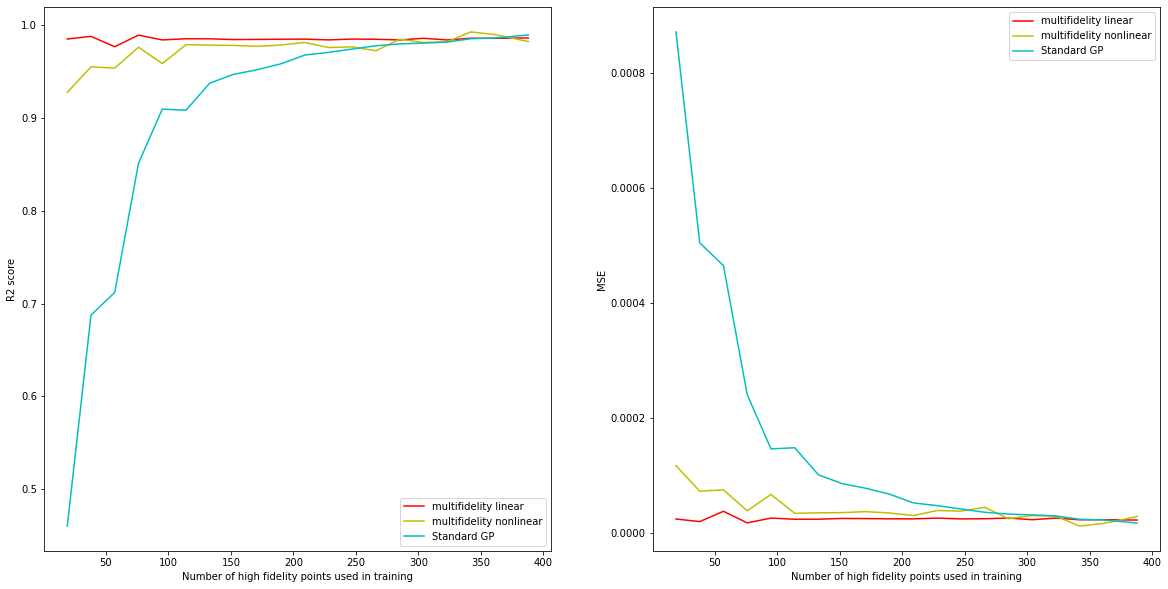

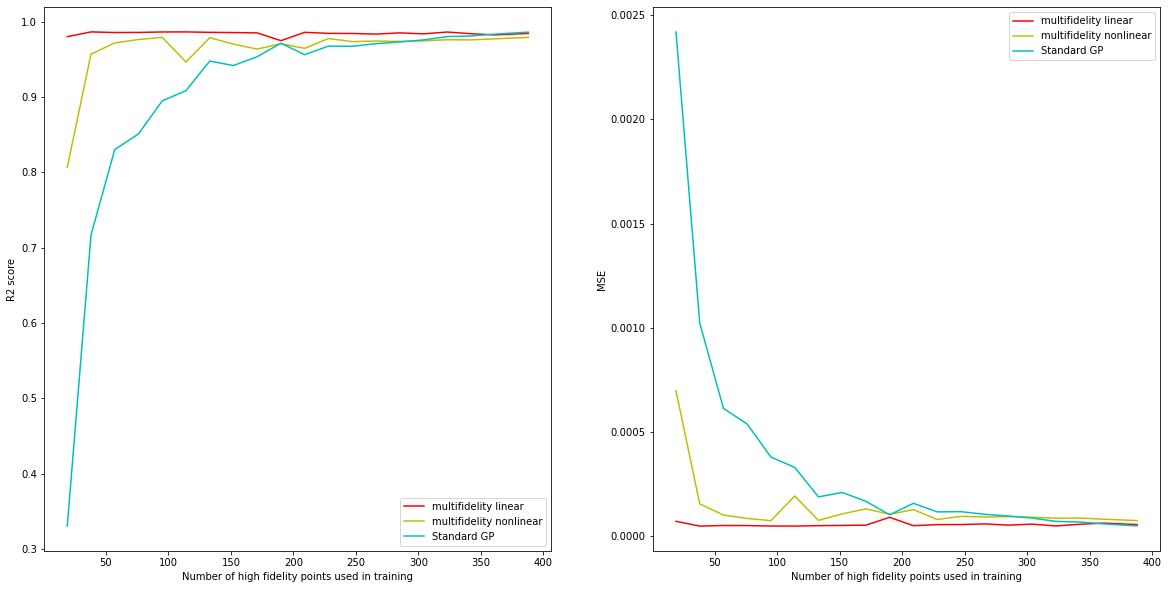

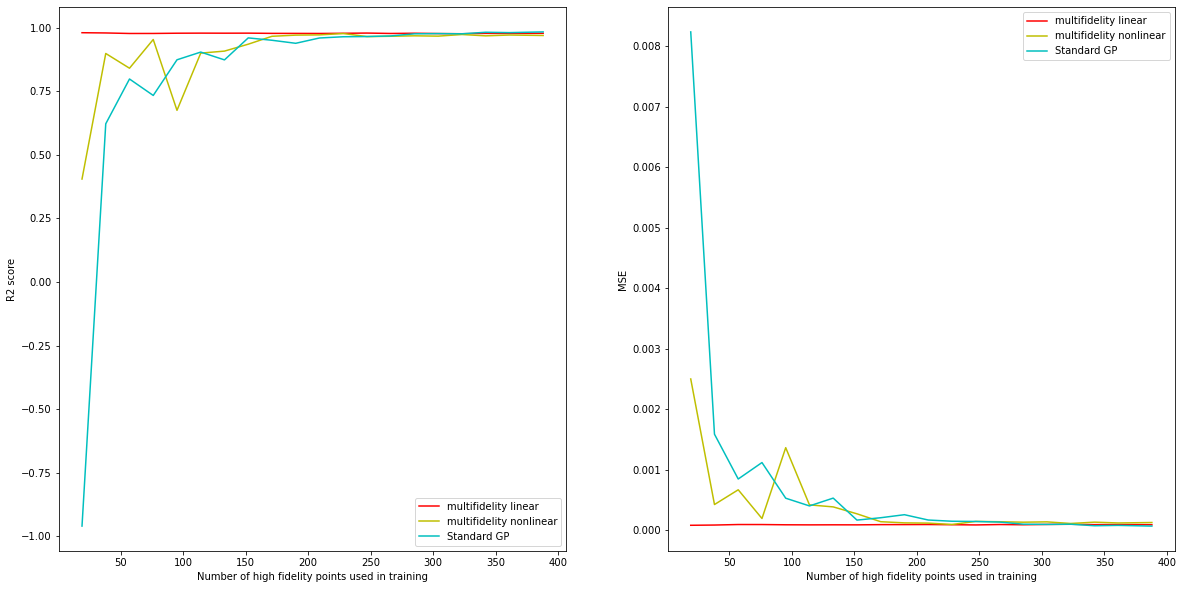

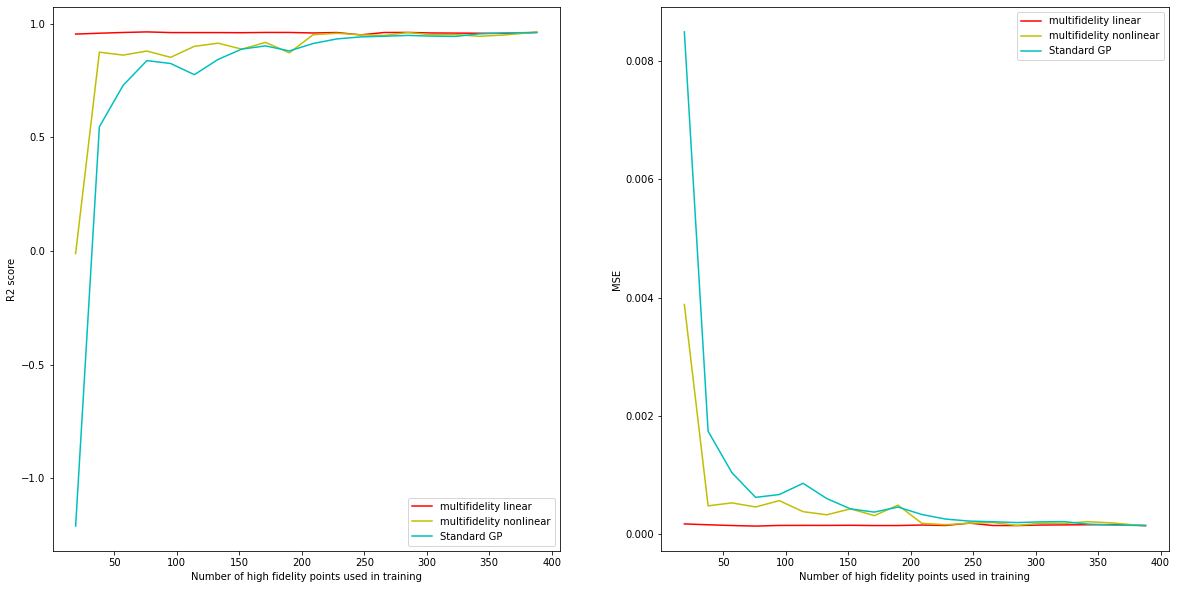

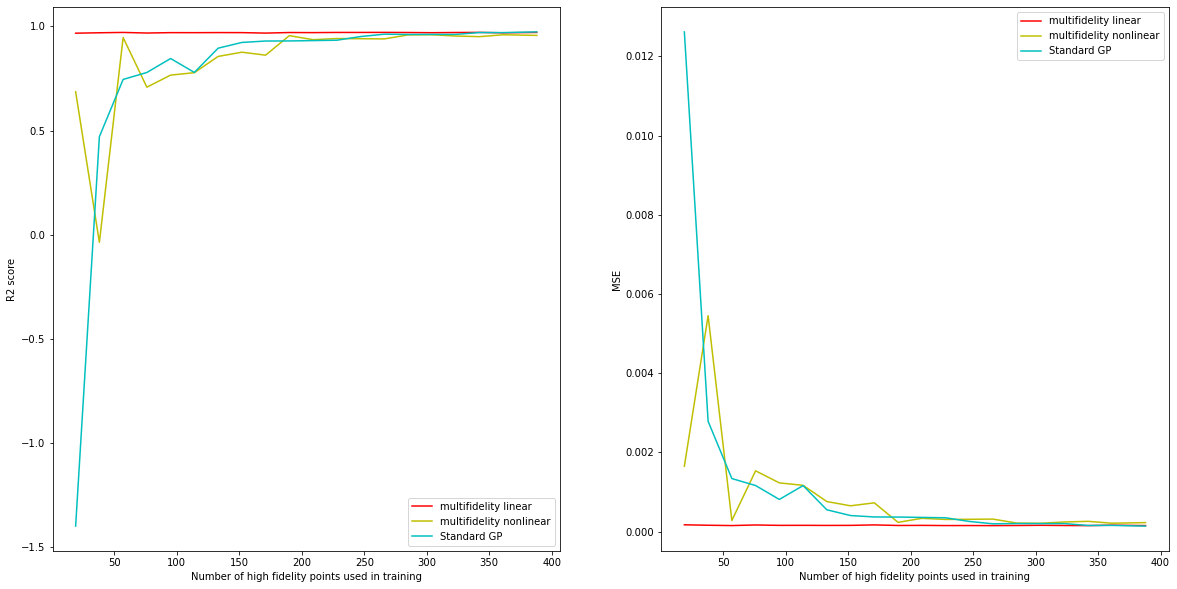

In [22]:
kf = KFold(n_splits=5)
Y_l=simulation_df[0][selected_observable].values.reshape(-1,1)
Y_h=simulation_df[1][selected_observable].values.reshape(-1,1)
n_batch = 20

val_i=0
for train_index, test_index in kf.split(X):
    val_i+=1
    r2_ar=[]
    mse_ar=[]
    batch_ar=[]
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train_h, x_test_h, y_train_h, y_test_h = X[train_index,:], X[test_index], Y_h[train_index,:], Y_h[test_index,:]
    x_train_l, x_test_l, y_train_l, y_test_l = X[train_index,:], X[test_index], Y_l[train_index,:], Y_l[test_index,:]
    
    for i in range(0,n_batch):
    
        l=0
        h=(train_index.shape[0]//n_batch)*(i+1)
        if i == n_batch-1:
            h=train_index.shape[0]
    ## Construct a linear multi-fidelity model
        mses, r2s = run_train_and_validation(x_train_l, x_train_h[l:h,:],x_test_h, y_train_l, y_train_h[l:h,:], y_test_h)
        r2_ar.append(r2s)
        mse_ar.append(mses)
        batch_ar.append(h)
    
    r2_ar = np.array(r2_ar)
    mse_ar = np.array(mse_ar)
    batch_ar = np.array(batch_ar)
    
    fig,ax =plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    ax1, ax2 = ax
    ax1.plot(batch_ar,r2_ar[:,0], c ='r', label='multifidelity linear')
    ax1.plot(batch_ar,r2_ar[:,1], c ='y', label='multifidelity nonlinear')
    ax1.plot(batch_ar,r2_ar[:,2], c ='c', label='Standard GP')
    #l,h=ax.get_ylim()
    #line_1d = np.linspace(l,h,100)
    #ax.plot(line_1d,line_1d)
    ax1.set_xlabel('Number of high fidelity points used in training')
    ax1.set_ylabel('R2 score')
    ax1.legend()
    
    ax2.plot(batch_ar,mse_ar[:,0], c ='r', label='multifidelity linear')
    ax2.plot(batch_ar,mse_ar[:,1], c ='y', label='multifidelity nonlinear')
    ax2.plot(batch_ar,mse_ar[:,2], c ='c', label='Standard GP')
    ax2.set_xlabel('Number of high fidelity points used in training')
    ax2.set_ylabel('MSE')
    ax2.legend()
    save_fig(f'{val_i}_batchsize_{n_batch} ARD')